In [12]:
import pyscf
from pyscf import mp, mcscf
import numpy as np
import h5py
import time
import scipy
import itertools
import copy
import matplotlib.pyplot as plt
import os, glob

MACHEPS = 1e-9
EH_TO_WN = 219474.63
EH_TO_EV = 27.211399

In [29]:
def antisymmetrize_2(T,indices):
    # antisymmetrize the residual
    T_anti = np.zeros(T.shape, dtype='complex128')
    T_anti += np.einsum("ijab->ijab",T)
    if indices[0] == indices[1]:
        T_anti -= np.einsum("ijab->jiab",T)
        if indices[2] == indices[3]:
            T_anti += np.einsum("ijab->jiba",T)
    if indices[2] == indices[3]:    
        T_anti -= np.einsum("ijab->ijba",T)        
    return T_anti

def zero_mat(mat):
    mat[np.abs(mat) < 1e-12] = 0
    return mat

def dsrg_HT(F, V, T1, T2, gamma1, eta1, lambda2, lambda3, mf):
    # All three terms for MRPT2/3 are the same, but just involve different F/V
    hc = mf.hc
    ha = mf.ha
    pa = mf.pa
    pv = mf.pv

    # all quantities are stored ^{hh..}_{pp..}
    # h = {c,a}; p = {a, v}
    E = 0.0
    E += +1.000 * np.einsum("iu,iv,vu->",F[hc,pa],T1[hc,pa],eta1,optimize="optimal")
    E += -0.500 * np.einsum("iu,ixvw,vwux->",F[hc,pa],T2[hc,ha,pa,pa],lambda2,optimize="optimal")
    E += +1.000 * np.einsum("ia,ia->",F[hc,pv],T1[hc,pv],optimize="optimal")
    E += +1.000 * np.einsum("ua,va,uv->",F[ha,pv],T1[ha,pv],gamma1,optimize="optimal")
    E += -0.500 * np.einsum("ua,wxva,uvwx->",F[ha,pv],T2[ha,ha,pa,pv],lambda2,optimize="optimal")
    E += -0.500 * np.einsum("iu,ivwx,uvwx->",T1[hc,pa],V[hc,ha,pa,pa],lambda2,optimize="optimal")
    E += -0.500 * np.einsum("ua,vwxa,vwux->",T1[ha,pv],V[ha,ha,pa,pv],lambda2,optimize="optimal")
    E += +0.250 * np.einsum("ijuv,ijwx,vx,uw->",T2[hc,hc,pa,pa],V[hc,hc,pa,pa],eta1,eta1,optimize="optimal")
    E += +0.125 * np.einsum("ijuv,ijwx,uvwx->",T2[hc,hc,pa,pa],V[hc,hc,pa,pa],lambda2,optimize="optimal")
    E += +0.500 * np.einsum("iwuv,ixyz,vz,uy,xw->",T2[hc,ha,pa,pa],V[hc,ha,pa,pa],eta1,eta1,gamma1,optimize="optimal")
    E += +1.000 * np.einsum("iwuv,ixyz,vz,uxwy->",T2[hc,ha,pa,pa],V[hc,ha,pa,pa],eta1,lambda2,optimize="optimal")
    E += +0.250 * np.einsum("iwuv,ixyz,xw,uvyz->",T2[hc,ha,pa,pa],V[hc,ha,pa,pa],gamma1,lambda2,optimize="optimal")
    E += +0.250 * np.einsum("iwuv,ixyz,uvxwyz->",T2[hc,ha,pa,pa],V[hc,ha,pa,pa],lambda3,optimize="optimal")
    E += +0.500 * np.einsum("ijua,ijva,uv->",T2[hc,hc,pa,pv],V[hc,hc,pa,pv],eta1,optimize="optimal")
    E += +1.000 * np.einsum("ivua,iwxa,ux,wv->",T2[hc,ha,pa,pv],V[hc,ha,pa,pv],eta1,gamma1,optimize="optimal")
    E += +1.000 * np.einsum("ivua,iwxa,uwvx->",T2[hc,ha,pa,pv],V[hc,ha,pa,pv],lambda2,optimize="optimal")
    E += +0.500 * np.einsum("vwua,xyza,uz,yw,xv->",T2[ha,ha,pa,pv],V[ha,ha,pa,pv],eta1,gamma1,gamma1,optimize="optimal")
    E += +0.250 * np.einsum("vwua,xyza,uz,xyvw->",T2[ha,ha,pa,pv],V[ha,ha,pa,pv],eta1,lambda2,optimize="optimal")
    E += +1.000 * np.einsum("vwua,xyza,yw,uxvz->",T2[ha,ha,pa,pv],V[ha,ha,pa,pv],gamma1,lambda2,optimize="optimal")
    E += -0.250 * np.einsum("vwua,xyza,uxyvwz->",T2[ha,ha,pa,pv],V[ha,ha,pa,pv],lambda3,optimize="optimal")
    E += +0.250 * np.einsum("ijab,ijab->",T2[hc,hc,pv,pv],V[hc,hc,pv,pv],optimize="optimal")
    E += +0.500 * np.einsum("iuab,ivab,vu->",T2[hc,ha,pv,pv],V[hc,ha,pv,pv],gamma1,optimize="optimal")
    E += +0.250 * np.einsum("uvab,wxab,xv,wu->",T2[ha,ha,pv,pv],V[ha,ha,pv,pv],gamma1,gamma1,optimize="optimal")
    E += +0.125 * np.einsum("uvab,wxab,wxuv->",T2[ha,ha,pv,pv],V[ha,ha,pv,pv],lambda2,optimize="optimal")
    return E

def Hbar_active_twobody_wicked(mf, F, V, T1, T2, gamma1, eta1):
    hc = mf.hc
    ha = mf.ha
    pa = mf.pa
    pv = mf.pv

    # all quantities are stored ^{hh..}_{pp..}
    # h = {c,a}; p = {a, v}
    
    _V = np.zeros((mf.nact,mf.nact,mf.nact,mf.nact), dtype='complex128')
    # Term 6
    _V += -0.500 * np.einsum("ua,wxva->wxuv",F[ha, pv], T2[ha,ha, pa,pv],optimize="optimal")
    # Term 7
    _V += -0.500 * np.einsum("iu,ixvw->uxvw",F[hc, pa], T2[hc,ha, pa,pa],optimize="optimal")
    # Term 8
    _V += -0.500 * np.einsum("iu,ivwx->wxuv",T1[hc,pa], V[hc,ha, pa,pa],optimize="optimal")
    # Term 9
    _V += -0.500 * np.einsum("ua,vwxa->uxvw",T1[ha,pv], V[ha,ha, pa,pv],optimize="optimal")
    # Term 10
    _V += +0.125 * np.einsum("uvab,wxab->uvwx", T2[ha,ha, pv,pv], V[ha,ha, pv,pv],optimize="optimal")
    _V += +0.250 * np.einsum("uvya,wxza,yz->uvwx", T2[ha,ha, pa,pv], V[ha,ha, pa,pv],eta1,optimize="optimal")
    # Term 11
    _V += +0.125 * np.einsum("ijuv,ijwx->wxuv", T2[hc,hc, pa,pa], V[hc,hc, pa,pa],optimize="optimal")
    _V += +0.250 * np.einsum("iyuv,izwx,zy->wxuv", T2[hc,ha, pa,pa], V[hc,ha, pa,pa],gamma1,optimize="optimal")
    # Term 12
    _V += +1.000 * np.einsum("ivua,iwxa->vxuw", T2[hc,ha, pa,pv], V[hc,ha, pa,pv],optimize="optimal")
    _V += +1.000 * np.einsum("ivuy,iwxz,yz->vxuw", T2[hc,ha, pa,pa], V[hc,ha, pa,pa],eta1,optimize="optimal")
    _V += +1.000 * np.einsum("vyua,wzxa,zy->vxuw", T2[ha,ha, pa,pv], V[ha,ha, pa,pv],gamma1,optimize="optimal")
    
    return antisymmetrize_2(_V.conj(), 'aaaa')

def Hbar_active_onebody_wicked(mf, F, V, T1, T2, gamma1, eta1, lambda2):
    hc = mf.hc
    ha = mf.ha
    pa = mf.pa
    pv = mf.pv

    # all quantities are stored ^{hh..}_{pp..}
    # h = {c,a}; p = {a,v}
    _F = np.zeros((mf.nact,mf.nact), dtype='complex128')
    _F += -1.000 * np.einsum("iu,iv->uv",F[hc, pa],T1[hc,pa],optimize="optimal")
    _F += -1.000 * np.einsum("iw,ivux,xw->vu",F[hc, pa], T2[hc,ha, pa,pa],eta1,optimize="optimal")
    _F += -1.000 * np.einsum("ia,ivua->vu",F[hc, pv], T2[hc,ha, pa,pv],optimize="optimal")
    _F += +1.000 * np.einsum("ua,va->vu",F[ha, pv],T1[ha,pv],optimize="optimal")
    _F += +1.000 * np.einsum("wa,vxua,wx->vu",F[ha, pv], T2[ha,ha, pa,pv],gamma1,optimize="optimal")
    _F += -1.000 * np.einsum("iw,iuvx,wx->vu",T1[hc,pa], V[hc,ha, pa,pa],eta1,optimize="optimal")
    _F += -1.000 * np.einsum("ia,iuva->vu",T1[hc,pv], V[hc,ha, pa,pv],optimize="optimal")
    _F += +1.000 * np.einsum("wa,uxva,xw->vu",T1[ha,pv], V[ha,ha, pa,pv],gamma1,optimize="optimal")
    _F += -0.500 * np.einsum("ijuw,ijvx,wx->vu", T2[hc,hc, pa,pa], V[hc,hc, pa,pa],eta1,optimize="optimal")
    _F += +0.500 * np.einsum("ivuw,ixyz,wxyz->vu", T2[hc,ha, pa,pa], V[hc,ha, pa,pa],lambda2,optimize="optimal")
    _F += -1.000 * np.einsum("ixuw,iyvz,wz,yx->vu", T2[hc,ha, pa,pa], V[hc,ha, pa,pa],eta1,gamma1,optimize="optimal")
    _F += -1.000 * np.einsum("ixuw,iyvz,wyxz->vu", T2[hc,ha, pa,pa], V[hc,ha, pa,pa],lambda2,optimize="optimal")
    _F += -0.500 * np.einsum("ijua,ijva->vu", T2[hc,hc, pa,pv], V[hc,hc, pa,pv],optimize="optimal")
    _F += -1.000 * np.einsum("iwua,ixva,xw->vu", T2[hc,ha, pa,pv], V[hc,ha, pa,pv],gamma1,optimize="optimal")
    _F += -0.500 * np.einsum("vwua,xyza,xywz->vu", T2[ha,ha, pa,pv], V[ha,ha, pa,pv],lambda2,optimize="optimal")
    _F += -0.500 * np.einsum("wxua,yzva,zx,yw->vu", T2[ha,ha, pa,pv], V[ha,ha, pa,pv],gamma1,gamma1,optimize="optimal")
    _F += -0.250 * np.einsum("wxua,yzva,yzwx->vu", T2[ha,ha, pa,pv], V[ha,ha, pa,pv],lambda2,optimize="optimal")
    _F += +0.500 * np.einsum("iuwx,ivyz,xz,wy->uv", T2[hc,ha, pa,pa], V[hc,ha, pa,pa],eta1,eta1,optimize="optimal")
    _F += +0.250 * np.einsum("iuwx,ivyz,wxyz->uv", T2[hc,ha, pa,pa], V[hc,ha, pa,pa],lambda2,optimize="optimal")
    _F += -0.500 * np.einsum("iywx,iuvz,wxyz->vu", T2[hc,ha, pa,pa], V[hc,ha, pa,pa],lambda2,optimize="optimal")
    _F += +1.000 * np.einsum("iuwa,ivxa,wx->uv", T2[hc,ha, pa,pv], V[hc,ha, pa,pv],eta1,optimize="optimal")
    _F += +1.000 * np.einsum("uxwa,vyza,wz,yx->uv", T2[ha,ha, pa,pv], V[ha,ha, pa,pv],eta1,gamma1,optimize="optimal")
    _F += +1.000 * np.einsum("uxwa,vyza,wyxz->uv", T2[ha,ha, pa,pv], V[ha,ha, pa,pv],lambda2,optimize="optimal")
    _F += +0.500 * np.einsum("xywa,uzva,wzxy->vu", T2[ha,ha, pa,pv], V[ha,ha, pa,pv],lambda2,optimize="optimal")
    _F += +0.500 * np.einsum("iuab,ivab->uv", T2[hc,ha, pv,pv], V[hc,ha, pv,pv],optimize="optimal")
    _F += +0.500 * np.einsum("uwab,vxab,xw->uv", T2[ha,ha, pv,pv], V[ha,ha, pv,pv],gamma1,optimize="optimal")

    return _F.conj()

def Hbar_active_twobody(mf, F, V, T1, T2, gamma1, eta1):
    hc = mf.hc
    ha = mf.ha
    pa = mf.pa
    pv = mf.pv
    hh = mf.hh
    pp = mf.pp

    # all quantities are stored ^{hh..}_{pp..}
    # h = {c,a}; p = {a, v}
    
    _V = np.zeros((mf.nact,mf.nact,mf.nact,mf.nact), dtype='complex128')

    # Term 6
    _V += +np.einsum("ue,wxev->wxuv",F[ha, pv], T2[ha,ha, pv,pa], optimize="optimal")
    _V += -np.einsum("ue,wxev->wxvu",F[ha, pv], T2[ha,ha, pv,pa], optimize="optimal")

    # Term 7
    _V += +np.einsum("mu,mxvw->xuvw",F[hc, pa], T2[hc,ha, pa,pa], optimize="optimal")
    _V += -np.einsum("mu,mxvw->uxvw",F[hc, pa], T2[hc,ha, pa,pa], optimize="optimal")

    # Term 8
    _V += +np.einsum("mu,vmwx->wxuv", T1[hc, pa], V[ha,hc, pa,pa], optimize="optimal")
    _V += -np.einsum("mu,vmwx->wxvu", T1[hc, pa], V[ha,hc, pa,pa], optimize="optimal")

    # Term 9
    _V += +np.einsum("ue,vwex->uxvw", T1[ha, pv], V[ha,ha, pv,pa], optimize="optimal")
    _V += -np.einsum("ue,vwex->xuvw", T1[ha, pv], V[ha,ha, pv,pa], optimize="optimal")
    
    # Term 10
    _V += +0.5*np.einsum("uvef,wxef->uvwx", T2[ha,ha, pv,pv], V[ha,ha, pv,pv], optimize="optimal")
    _V += +np.einsum("uvye,wxze,yz->uvwx", T2[ha,ha, pa,pv], V[ha,ha, pa,pv], eta1, optimize="optimal")

    # Term 11
    _V += +0.5*np.einsum("mnuv,mnwx->wxuv", T2[hc,hc, pa,pa], V[hc,hc, pa,pa], optimize="optimal")
    _V += +np.einsum("myuv,mzwx,zy->wxuv", T2[hc,ha, pa,pa], V[hc,ha, pa,pa], gamma1, optimize="optimal")

    # Term 12
    _V += +np.einsum("mvua,mwxa->vxuw", T2[hc,ha, pa,pp], V[hc,ha, pa,pp], optimize="optimal")
    _V += -np.einsum("mvua,mwxa->xvuw", T2[hc,ha, pa,pp], V[hc,ha, pa,pp], optimize="optimal")
    _V += -np.einsum("mvua,mwxa->vxwu", T2[hc,ha, pa,pp], V[hc,ha, pa,pp], optimize="optimal")
    _V += +np.einsum("mvua,mwxa->xvwu", T2[hc,ha, pa,pp], V[hc,ha, pa,pp], optimize="optimal")

    _V -= +np.einsum("muyv,mxzw,zy->vxuw", T2[hc,ha, pa,pa], V[hc,ha, pa,pa], gamma1, optimize="optimal")
    _V -= -np.einsum("muyv,mxzw,zy->xvuw", T2[hc,ha, pa,pa], V[hc,ha, pa,pa], gamma1, optimize="optimal")
    _V -= -np.einsum("muyv,mxzw,zy->vxwu", T2[hc,ha, pa,pa], V[hc,ha, pa,pa], gamma1, optimize="optimal")
    _V -= +np.einsum("muyv,mxzw,zy->xvwu", T2[hc,ha, pa,pa], V[hc,ha, pa,pa], gamma1, optimize="optimal")
        
    _V += +np.einsum("vyue,wzxe,zy->vxuw", T2[ha,ha, pa,pv], V[ha,ha, pa,pv], gamma1, optimize="optimal")
    _V += -np.einsum("vyue,wzxe,zy->xvuw", T2[ha,ha, pa,pv], V[ha,ha, pa,pv], gamma1, optimize="optimal")
    _V += -np.einsum("vyue,wzxe,zy->vxwu", T2[ha,ha, pa,pv], V[ha,ha, pa,pv], gamma1, optimize="optimal")
    _V += +np.einsum("vyue,wzxe,zy->xvwu", T2[ha,ha, pa,pv], V[ha,ha, pa,pv], gamma1, optimize="optimal")
    
    return _V

def Hbar_active_onebody(mf, F, V, T1, T2, gamma1, eta1, lambda2):
    hc = mf.hc
    ha = mf.ha
    pa = mf.pa
    pv = mf.pv
    hh = mf.hh
    pp = mf.pp

    # all quantities are stored ^{hh..}_{pp..}
    # h = {c,a}; p = {a,v}
    _F = np.zeros((mf.nact,mf.nact), dtype='complex128')

    # Term 2
    ## First term
    _F += +1.000 * np.einsum("ua,va->vu", F[ha, pv], T1[ha, pv], optimize="optimal")
    ## Second term vanishes for F_AA
    ## Third term gives rise to 5 distinct contractions
    _F += +0.500 * np.einsum("muef,mvef->uv", T2[hc,ha, pv,pv], V[hc,ha, pv,pv], optimize="optimal")
    _F += +0.500 * np.einsum("wuef,xvef,xw->uv", T2[ha,ha, pv,pv], V[ha,ha, pv,pv], gamma1, optimize="optimal")
    _F += +1.000 * np.einsum("muew,mvex,wx->uv", T2[hc,ha, pv,pa], V[hc,ha, pv,pa], eta1, optimize="optimal")
    _F += +1.000 * np.einsum("xuew,yvez,wz,yx->uv", T2[ha,ha, pv,pa], V[ha,ha, pv,pa], eta1, gamma1, optimize="optimal")
    _F += +0.500 * np.einsum("muwy,mvxz,wx,yz->uv", T2[hc,ha, pa,pa], V[hc,ha, pa,pa], eta1, eta1, optimize="optimal")
    ## Fourth term
    _F += +0.250 * np.einsum("muwx,mvyz,wxyz->uv", T2[hc,ha, pa,pa], V[hc,ha, pa,pa], lambda2, optimize="optimal")
    ## Fifth term
    _F += +1.000 * np.einsum("uxwe,vyze,wyxz->uv", T2[ha,ha, pa,pv], V[ha,ha, pa,pv], lambda2, optimize="optimal")    

    # Term 3
    ## First term
    _F += -1.000 * np.einsum("mu,mv->uv", F[hc, pa], T1[hc, pa], optimize="optimal")
    ## Second term again vanishes
    ## Third term again gives rise to 5 distinct contractions
    _F += -0.500 * np.einsum("mnue,mnve->vu", T2[hc,hc, pa,pv], V[hc,hc, pa,pv], optimize="optimal")
    _F += -0.500 * np.einsum("mnuw,mnvx,wx->vu", T2[hc,hc, pa,pa], V[hc,hc, pa,pa], eta1, optimize="optimal")
    _F += -1.000 * np.einsum("mwue,mxve,xw->vu", T2[hc,ha, pa,pv], V[hc,ha, pa,pv], gamma1, optimize="optimal")
    _F += -1.000 * np.einsum("mxuw,myvz,wz,yx->vu", T2[hc,ha, pa,pa], V[hc,ha, pa,pa], eta1, gamma1, optimize="optimal")
    _F += -0.500 * np.einsum("wxue,yzve,zx,yw->vu", T2[ha,ha, pa,pv], V[ha,ha, pa,pv], gamma1, gamma1, optimize="optimal")
    ## Fourth term
    _F += -0.250 * np.einsum("wxue,yzve,yzwx->vu", T2[ha,ha, pa,pv], V[ha,ha, pa,pv], lambda2, optimize="optimal")
    ## Fifth term
    _F += -1.000 * np.einsum("ixuw,iyvz,wyxz->vu", T2[hc,ha, pa,pa], V[hc,ha, pa,pa], lambda2, optimize="optimal")
    
    # Term 4
    ## First term: two distinct contractions
    _F += +1.000 * np.einsum("we,vxue,wx->vu", F[ha, pv], T2[ha,ha, pa,pv], gamma1, optimize="optimal")
    _F += +1.000 * np.einsum("ma,vmua->vu", F[hc, pp], T2[ha,hc, pa,pp], optimize="optimal") 
    _F += -1.000 * np.einsum("mw,mvxu,xw->uv",F[hc, pa], T2[hc,ha, pa,pa], gamma1, optimize="optimal")
    ## Third term
    _F += +0.500 * np.einsum("mvuw,mxyz,wxyz->vu", T2[hc,ha, pa,pa], V[hc,ha, pa,pa], lambda2, optimize="optimal")
    ## Fourth term
    _F += -0.500 * np.einsum("vwue,xyze,xywz->vu", T2[ha,ha, pa,pv], V[ha,ha, pa,pv], lambda2, optimize="optimal")

    # Term 5
    ## First term
    _F += +1.000 * np.einsum("wa,uxva,xw->vu", T1[ha, pv], V[ha,ha, pa,pv], gamma1, optimize="optimal")
    _F += -1.000 * np.einsum("ia,iuva->vu", T1[hc, pp], V[hc,ha, pa,pp], optimize="optimal")
    ## Second term
    _F += -1.000 * np.einsum("iw,iuxv,wx->vu", T1[hc, pa], V[hc,ha, pa,pa], gamma1, optimize="optimal")
    ## Third term
    _F += +0.500 * np.einsum("xywa,uzva,wzxy->vu", T2[ha,ha, pa,pv], V[ha,ha, pa,pv], lambda2, optimize="optimal")
    ## Fourth term
    _F += -0.500 * np.einsum("iywx,iuvz,wxyz->vu", T2[hc,ha, pa,pa], V[hc,ha, pa,pa],lambda2,optimize="optimal")
    return _F

def regularized_denominator(x, s):
    if abs(x) <= MACHEPS:
        return 0.0
    return (1. - np.exp(-s * x**2)) / x

def set_bit(bit_loc):
    """
    Set the bit_loc-th bit in bit string f. Returns unchanged if the bit is already set. bit_loc is zero-indexed.
    """
    f = 0
    for loc in bit_loc:
        f = f | 1<<loc
    return f

def set_bit_single(f, bit_loc):
    """
    Set the bit_loc-th bit in bit string f. Returns unchanged if the bit is already set. bit_loc is zero-indexed.
    """
    return f | 1<<bit_loc

def clear_bit(f, bit_loc):
    """
    Unset the bit_loc-th bit in bit string f. Returns unchanged if the bit is already unset. bit_loc is zero-indexed.
    """
    return f & ~(1<<bit_loc)

def test_bit(f, bit_loc):
    """
    Test if bit_loc in f is set. Returns 1 if set, 0 if not set.
    """
    return (f & (1<<bit_loc)) >> bit_loc

def count_set_bits(f):
    """
    Return the number of set (1) bits in the bit string f.
    """
    return int(bin(f).count('1'))

def get_excitation_level(f1, f2):
    """
    Get the excitation level between two bit strings f1 and f2, i.e., half the Hamming distance.
    """
    return int(count_set_bits(f1^f2)/2)

def annop(bit_string, ispinor):
    """
    Annihilation operator, annihilates spinorb in bit_string, returns the sign and the resulting bit string.
    If spinorb is already empty, sign is zero and the bit string is returned unchanged.
    """
    if (not test_bit(bit_string, ispinor)):
        sgn = 0
    else:
        test_string = 0
        for i in range(ispinor):
            test_string = set_bit_single(test_string, i)
        sgn = (-1)**(count_set_bits(bit_string & test_string))
        bit_string = clear_bit(bit_string, ispinor)
    return (sgn, bit_string)
    
def bstring_to_occ_vec(f, nelec, norbs):
    occ_vec = np.zeros(nelec, dtype='int')
    nfound = 0
    for i in range(norbs):
        if test_bit(f, i)==1:
            occ_vec[nfound] = i
            nfound += 1
            if (nfound==nelec):
                break
    return occ_vec

def bstring_to_unocc_vec(f, nelec, norbs):
    unocc_vec = np.zeros(norbs-nelec, dtype='int')
    nfound = 0
    for i in range(norbs):
        if test_bit(f, i)==0:
            unocc_vec[nfound] = i
            nfound += 1
            if (nfound==norbs-nelec):
                break
    return unocc_vec

def get_excit_connection(f1, f2, exlvl, nelec, norbs):
    excit_bstring = f1^f2
    
    excit = np.zeros((2,exlvl), dtype='int')
    nbit_f1_found = 0
    nbit_f2_found = 0
    for i in range(norbs):
        if (test_bit(excit_bstring, i)==1):
            # Check where this electron is coming from / going to
            if (test_bit(f1, i)):
                excit[0][nbit_f1_found] = i
                nbit_f1_found += 1
            else:
                excit[1][nbit_f2_found] = i
                nbit_f2_found += 1
            if (nbit_f1_found == exlvl and nbit_f2_found==exlvl):
                break
                
    # Get permutation!
    perm = annop_mult(f1, excit[0])[0] * annop_mult(f2, excit[1])[0]

    return excit, perm

def annop_mult(f, orbs):
    fold = f
    perm = 1
    for orb in orbs:
        iperm, fnew = annop(fold, orb)
        perm *= iperm
        fold = fnew
    
    return perm, fnew

def make_cumulants(rdm):
    try:
        assert rdm['max_rdm_level'] >= 2
    except AssertionError:
        raise Exception('Max RDM level is 1, cumulants not necessary!')
        
    _lamb = {'max_cumulant_level':rdm['max_rdm_level']}
    _lamb['gamma1'] = rdm['1rdm']
    _lamb['eta1'] = -rdm['1rdm'] + np.diag(np.zeros(rdm['1rdm'].shape[0])+1)
    _lamb['lambda2'] = rdm['2rdm'] - np.einsum('pr,qs->pqrs', rdm['1rdm'], rdm['1rdm']) + np.einsum('ps,qr->pqrs', rdm['1rdm'], rdm['1rdm'])
    if (rdm['max_rdm_level'] == 3):
        _lamb['lambda3'] = rdm['3rdm'] - np.einsum('ps,qrtu->pqrstu',rdm['1rdm'],rdm['2rdm']) + np.einsum('pt,qrsu->pqrstu',rdm['1rdm'],rdm['2rdm']) + np.einsum('pu,qrts->pqrstu',rdm['1rdm'],rdm['2rdm'])- np.einsum('qt,prsu->pqrstu',rdm['1rdm'],rdm['2rdm']) + np.einsum('qs,prtu->pqrstu',rdm['1rdm'],rdm['2rdm']) + np.einsum('qu,prst->pqrstu',rdm['1rdm'],rdm['2rdm'])- np.einsum('ru,pqst->pqrstu',rdm['1rdm'],rdm['2rdm']) + np.einsum('rs,pqut->pqrstu',rdm['1rdm'],rdm['2rdm']) + np.einsum('rt,pqsu->pqrstu',rdm['1rdm'],rdm['2rdm'])+ 2*(np.einsum('ps,qt,ru->pqrstu',rdm['1rdm'],rdm['1rdm'],rdm['1rdm']) + np.einsum('pt,qu,rs->pqrstu',rdm['1rdm'],rdm['1rdm'],rdm['1rdm']) + np.einsum('pu,qs,rt->pqrstu',rdm['1rdm'],rdm['1rdm'],rdm['1rdm']))- 2*(np.einsum('ps,qu,rt->pqrstu',rdm['1rdm'],rdm['1rdm'],rdm['1rdm']) + np.einsum('pu,qt,rs->pqrstu',rdm['1rdm'],rdm['1rdm'],rdm['1rdm']) + np.einsum('pt,qs,ru->pqrstu',rdm['1rdm'],rdm['1rdm'],rdm['1rdm']))
                
    return _lamb

def cq_to_pyscf(mol, bin_name):
    """
    Reorder ChronusQuantum DHF MO coeffs to PySCF order, and transform to spinor AO basis.
    CQ order:    [La1, La2, ..., Sa1, Sa2, ..., Lb1, Lb2, ..., Sb1, Sb2, ...]
    PySCF order: [La1, Lb1, ..., Sa1, Sb1, ...]
    """
    f = h5py.File(bin_name, 'r')
    mo_cq = f['SCF']['MO1'][:]

    nspinor = mo_cq.shape[0]//2
    coeffs_reorder = np.zeros_like(mo_cq)
    coeffs_reorder[::2,:] = mo_cq[:,:nspinor].T
    coeffs_reorder[1::2,:] = mo_cq[:,nspinor:].T

    coeffs_spinor = sph_to_spinor(mol, coeffs_reorder)[0]

    return coeffs_spinor

def sph_to_spinor(mol, coeffs):
    """
    Transfer DHF MOs coefficients in a real spherical AO spinor basis,
    >>> e.g. {p_xa, p_xb, p_ya, p_yb, p_za, p_zb},
    >>> each of the above is a two-spinor, for example, p_xa=(px, 0), p_xb=(0, px) etc.
    to the corresponding complex spinor basis.
    >>> e.g. {p_{1/2,-1/2}, p_{1/2,+1/2}, p_{3/2,-3/2}, p_{3/2,-1/2}, p_{3/2,+1/2}, p_{3/2,+3/2}},
    >>> each of the above is a two-spinor, for example, p_{1/2,-1/2} = (x-iy, z)/sqrt(3)
    """
    nspinor = coeffs.shape[0]//2
    rotmat = np.zeros((nspinor,nspinor), dtype='complex128')
    rotmat[::2,:] = mol.sph2spinor_coeff()[0]
    rotmat[1::2,:] = mol.sph2spinor_coeff()[1]

    mo_rot = coeffs.copy()
    # To see why the complex conjugate needs to be taken, we use an example:
    # p_{1/2,-1/2} \propto (x-iy, z), so our rotmat gives for the column of p_{1/2,-1/2}
    # [1, 0, -i, 0, 0, -1] for the real spherical AO spinors [pxa, pxb, pya, pyb, pza, pzb].
    # This means to rotate this linear combination of real spherical p spinors to p_{1/2,-1/2} 
    # (i.e., [-1, 0, 0, 0, 0, 0] in the complex representation),
    # we need to dot it with [1, 0, i, 0, 0, -1], which suggests that we need to take the complex conjugate of the rotmat.
    mo_rot[:nspinor,:] = np.einsum('uv,ui->vi', np.conj(rotmat), coeffs[:nspinor,:])
    mo_rot[nspinor:,:] = np.einsum('uv,ui->vi', np.conj(rotmat), coeffs[nspinor:,:])
    
    return mo_rot, rotmat

def form_cas_hamiltonian(H1body, H2body, det_strings, verbose, cas, ncore=0):
    ncombs = len(det_strings)
    _mem = ncombs**2*16/1e9
    if (_mem < 1.0):
        if (verbose): print(f'Will now allocate {_mem*1000:.3f} MB memory for the CASCI Hamiltonian!')
    else:
        if (verbose): print(f'Will now allocate {_mem:.3f} GB memory for the CASCI Hamiltonian!')
    _hamil_det = np.zeros((ncombs,ncombs), dtype='complex128')
    for i in range(ncombs):
        for j in range(i+1):
            exlvl = get_excitation_level(det_strings[i], det_strings[j])
            if (exlvl <= 2):
                if (i==j):
                    occ = bstring_to_occ_vec(det_strings[i], *cas)
                    _hamil_det[i,i] = 0
                    for iocc in occ:
                        _hamil_det[i,i] += H1body[iocc,iocc]
                        for jocc in occ:
                            _hamil_det[i,i] += 0.5*H2body[iocc+ncore,jocc+ncore,iocc+ncore,jocc+ncore]
                elif (exlvl == 1):
                    occ = bstring_to_occ_vec(det_strings[i], *cas)
                    conn, perm = get_excit_connection(det_strings[i], det_strings[j], exlvl, *cas)
                    _hamil_det[i,j] = H1body[conn[0],conn[1]]
                    for iocc in occ:
                        _hamil_det[i,j] += H2body[conn[0]+ncore, iocc+ncore, conn[1]+ncore, iocc+ncore]

                    _hamil_det[i,j] *= perm
                    _hamil_det[j,i] = np.conj(_hamil_det[i,j])
                elif (exlvl == 2):
                    conn, perm = get_excit_connection(det_strings[i], det_strings[j], exlvl, *cas)
                    _hamil_det[i,j] = perm*H2body[conn[0][0]+ncore, conn[0][1]+ncore, conn[1][0]+ncore, conn[1][1]+ncore]
                    _hamil_det[j,i] = np.conj(_hamil_det[i,j])         
    return _hamil_det

def get_hamil_element(f0, f1, H1body, H2body, cas, ncore=0):
    """
    <f0|H|f1>
    """
    _hmatel = 0.0j
    exlvl = get_excitation_level(f0, f1)
    if (exlvl <= 2):
        if (exlvl == 0):
            occ = bstring_to_occ_vec(f0, *cas)
            _hmatel = 0
            for iocc in occ:
                _hmatel += H1body[iocc,iocc]
                for jocc in occ:
                    _hmatel += 0.5*H2body[iocc+ncore,jocc+ncore,iocc+ncore,jocc+ncore]
        elif (exlvl == 1):
            occ = bstring_to_occ_vec(f0, *cas)
            conn, perm = get_excit_connection(f0, f1, exlvl, *cas)
            _hmatel = H1body[conn[0],conn[1]]
            for iocc in occ:
                _hmatel += H2body[conn[0]+ncore, iocc+ncore, conn[1]+ncore, iocc+ncore]
            _hmatel *= perm
        elif (exlvl == 2):
            conn, perm = get_excit_connection(f0, f1, exlvl, *cas)
            _hmatel = perm*H2body[conn[0][0]+ncore, conn[0][1]+ncore, conn[1][0]+ncore, conn[1][1]+ncore]
    
    return _hmatel

def form_cas_determinant_strings(nelec, norbs):
    """
    Returns the unrestricted (no spin or spatial symmetry imposed) list of bitstrings in a (nelec, n(spin(or))orbs) CAS.
    """
    ncombs = scipy.special.comb(norbs, nelec, exact=True)
    det_strings = list(map(set_bit, list(itertools.combinations(range(norbs),nelec))))
    assert(len(det_strings) == ncombs)

    return ncombs, det_strings

def form_cas_determinant_strings_general(occlist, actlist, nelec):
    """
    Returns the unrestricted (no spin or spatial symmetry imposed) list of bitstrings in the active space generated by distributing nelec in the occlist.
    """
    # just in case..
    actlist = list(np.sort(actlist)) 
    occlist = list(np.sort(occlist)) 
    norbs = len(actlist)
    
    ncombs = scipy.special.comb(norbs, nelec, exact=True)
    det_strings = list(map(set_bit, [list(_) + occlist for _ in list(itertools.combinations(actlist,nelec))] ))
    assert(len(det_strings) == ncombs)

    return ncombs, det_strings

def get_1_rdm_sa(det_strings, cas, states, weights, verbose):
    _sa_rdm = np.zeros((cas[1],cas[1]), dtype='complex128')
    for i in range(len(weights)):
        _sa_rdm += weights[i] * get_1_rdm(det_strings, cas, states[i], verbose)
    return _sa_rdm

def get_2_rdm_sa(det_strings, cas, states, weights, verbose):
    _sa_rdm = np.zeros((cas[1],cas[1],cas[1],cas[1]), dtype='complex128')
    for i in range(len(weights)):
        _sa_rdm += weights[i] * get_2_rdm(det_strings, cas, states[i], verbose)
    return _sa_rdm

def get_3_rdm_sa(det_strings, cas, states, weights, verbose):
    _sa_rdm = np.zeros((cas[1],cas[1],cas[1],cas[1],cas[1],cas[1]), dtype='complex128')
    for i in range(len(weights)):
        _sa_rdm += weights[i] * get_3_rdm(det_strings, cas, states[i], verbose)
    return _sa_rdm

def get_1_rdm(det_strings, cas, psi, verbose):
    _t0 = time.time()
    _rdm = np.zeros((cas[1],cas[1]), dtype='complex128')
    for i in range(len(det_strings)):
        occ_vec = bstring_to_occ_vec(det_strings[i], *cas)
        contrib = np.conjugate(psi[i])*psi[i]
        for p in occ_vec:
            _rdm[p, p] += contrib
        for j in range(len(det_strings)):
            if (get_excitation_level(det_strings[i], det_strings[j]) == 1):
                [[p], [q]], perm = get_excit_connection(det_strings[i], det_strings[j], 1, *cas)
                _rdm[p, q] += perm*np.conjugate(psi[i])*psi[j]
    _t1 = time.time()
    if (verbose): print(f'Time taken for 1-RDM build:  {(_t1-_t0):15.7f} s')
    return _rdm

def get_2_rdm(det_strings, cas, psi, verbose):
    _t0 = time.time()
    _rdm = np.zeros((cas[1],cas[1],cas[1],cas[1]), dtype='complex128')
    if (cas[0] < 2): return _rdm
    for i in range(len(det_strings)):
        # <p+ q+ q p>
        occ_vec = bstring_to_occ_vec(det_strings[i], *cas)
        # get all possible pairs of occupied spinorb
        contrib = np.conjugate(psi[i])*psi[i]
        for ip, p in enumerate(occ_vec):
            for q in occ_vec[:ip]:
                _rdm[p, q, p, q] += contrib
                _rdm[p, q, q, p] -= contrib
                _rdm[q, p, p, q] -= contrib
                _rdm[q, p, q, p] += contrib
        
        for j in range(len(det_strings)):
            exlvl = get_excitation_level(det_strings[i], det_strings[j])
            
            if (exlvl==1):
                # We need to accumulate all <p+ q+ q r>, it's sufficient to get the parity of <p+ r> since q+ q always cancel out
                [[p],[r]], perm = get_excit_connection(det_strings[i], det_strings[j], 1, *cas)
                f = annop(det_strings[i],p)[1]
                occ_vec = bstring_to_occ_vec(f, cas[0]-1, cas[1])
                contrib = perm*np.conjugate(psi[i])*psi[j]
                for q in occ_vec:
                    _rdm[p, q, r, q] += contrib
                    _rdm[p, q, q, r] -= contrib
                    _rdm[q, p, r, q] -= contrib
                    _rdm[q, p, q, r] += contrib
            elif (exlvl==2):
                # <p+ q+ s r>
                conn, perm = get_excit_connection(det_strings[i], det_strings[j], 2, *cas)
                p, q = conn[0] # get_excit_connection's perm is <q+ p+ r s>
                r, s = conn[1] # conn is in ascending order in spinor index, 
                contrib = perm*np.conjugate(psi[i])*psi[j]
                _rdm[p, q, r, s] += contrib
                _rdm[p, q, s, r] -= contrib
                _rdm[q, p, r, s] -= contrib
                _rdm[q, p, s, r] += contrib
    _t1 = time.time()
    if (verbose): print(f'Time taken for 2-RDM build:  {(_t1-_t0):15.7f} s')
    return _rdm

def get_3_rdm(det_strings, cas, psi, verbose):
    """
    gamma3^{pqr}_{stu} = <p+ q+ r+ u t s>
    """
    _t0 = time.time()
    _rdm = np.zeros((cas[1],cas[1],cas[1],cas[1],cas[1],cas[1]), dtype='complex128')
    if (cas[0] < 3): return _rdm
    for i in range(len(det_strings)):
        occ_vec = bstring_to_occ_vec(det_strings[i], *cas)
        # get all possible triplets of occupied spinors
        contrib = np.conjugate(psi[i])*psi[i]
        for ip, p in enumerate(occ_vec):
            for iq, q in enumerate(occ_vec[:ip]):
                for r in occ_vec[:iq]:
                    _rdm[p, q, r, p, q, r] += contrib
                    _rdm[q, r, p, p, q, r] += contrib
                    _rdm[r, p, q, p, q, r] += contrib
                    _rdm[p, r, q, p, q, r] -= contrib
                    _rdm[r, q, p, p, q, r] -= contrib
                    _rdm[q, p, r, p, q, r] -= contrib
                        
                    _rdm[p, q, r, q, r, p] += contrib
                    _rdm[q, r, p, q, r, p] += contrib
                    _rdm[r, p, q, q, r, p] += contrib
                    _rdm[p, r, q, q, r, p] -= contrib
                    _rdm[r, q, p, q, r, p] -= contrib
                    _rdm[q, p, r, q, r, p] -= contrib
                    
                    _rdm[p, q, r, r, p, q] += contrib
                    _rdm[q, r, p, r, p, q] += contrib
                    _rdm[r, p, q, r, p, q] += contrib
                    _rdm[p, r, q, r, p, q] -= contrib
                    _rdm[r, q, p, r, p, q] -= contrib
                    _rdm[q, p, r, r, p, q] -= contrib

                    _rdm[p, q, r, p, r, q] -= contrib
                    _rdm[q, r, p, p, r, q] -= contrib
                    _rdm[r, p, q, p, r, q] -= contrib
                    _rdm[p, r, q, p, r, q] += contrib
                    _rdm[r, q, p, p, r, q] += contrib
                    _rdm[q, p, r, p, r, q] += contrib
                    
                    _rdm[p, q, r, r, q, p] -= contrib
                    _rdm[q, r, p, r, q, p] -= contrib
                    _rdm[r, p, q, r, q, p] -= contrib
                    _rdm[p, r, q, r, q, p] += contrib
                    _rdm[r, q, p, r, q, p] += contrib
                    _rdm[q, p, r, r, q, p] += contrib
                    
                    _rdm[p, q, r, q, p, r] -= contrib
                    _rdm[q, r, p, q, p, r] -= contrib
                    _rdm[r, p, q, q, p, r] -= contrib
                    _rdm[p, r, q, q, p, r] += contrib
                    _rdm[r, q, p, q, p, r] += contrib
                    _rdm[q, p, r, q, p, r] += contrib
        
        for j in range(len(det_strings)):
            exlvl = get_excitation_level(det_strings[i], det_strings[j])
            
            if (exlvl==1):
                # We need to accumulate all <p+ q+ r+ r q s>, it's sufficient to get the parity of <p+ s> since q+r+ rq always cancel out
                [[p], [s]], perm = get_excit_connection(det_strings[i], det_strings[j], 1, *cas)
                f = annop(det_strings[i],p)[1]
                occ_vec = bstring_to_occ_vec(f, cas[0]-1, cas[1])
                contrib = perm*np.conjugate(psi[i])*psi[j]
                for iq, q in enumerate(occ_vec):
                    # q cannot be == r as violates exclusion principle
                    for r in occ_vec[:iq]:
                        _rdm[p, q, r, s, q, r] += contrib
                        _rdm[q, r, p, s, q, r] += contrib
                        _rdm[r, p, q, s, q, r] += contrib
                        _rdm[p, r, q, s, q, r] -= contrib
                        _rdm[r, q, p, s, q, r] -= contrib
                        _rdm[q, p, r, s, q, r] -= contrib

                        _rdm[p, q, r, q, r, s] += contrib
                        _rdm[q, r, p, q, r, s] += contrib
                        _rdm[r, p, q, q, r, s] += contrib
                        _rdm[p, r, q, q, r, s] -= contrib
                        _rdm[r, q, p, q, r, s] -= contrib
                        _rdm[q, p, r, q, r, s] -= contrib

                        _rdm[p, q, r, r, s, q] += contrib
                        _rdm[q, r, p, r, s, q] += contrib
                        _rdm[r, p, q, r, s, q] += contrib
                        _rdm[p, r, q, r, s, q] -= contrib
                        _rdm[r, q, p, r, s, q] -= contrib
                        _rdm[q, p, r, r, s, q] -= contrib

                        _rdm[p, q, r, s, r, q] -= contrib
                        _rdm[q, r, p, s, r, q] -= contrib
                        _rdm[r, p, q, s, r, q] -= contrib
                        _rdm[p, r, q, s, r, q] += contrib
                        _rdm[r, q, p, s, r, q] += contrib
                        _rdm[q, p, r, s, r, q] += contrib

                        _rdm[p, q, r, r, q, s] -= contrib
                        _rdm[q, r, p, r, q, s] -= contrib
                        _rdm[r, p, q, r, q, s] -= contrib
                        _rdm[p, r, q, r, q, s] += contrib
                        _rdm[r, q, p, r, q, s] += contrib
                        _rdm[q, p, r, r, q, s] += contrib

                        _rdm[p, q, r, q, s, r] -= contrib
                        _rdm[q, r, p, q, s, r] -= contrib
                        _rdm[r, p, q, q, s, r] -= contrib
                        _rdm[p, r, q, q, s, r] += contrib
                        _rdm[r, q, p, q, s, r] += contrib
                        _rdm[q, p, r, q, s, r] += contrib
            if (exlvl==2):
                # We need to accumulate all <p+ q+ r+ r t s>
                conn, perm = get_excit_connection(det_strings[i], det_strings[j], 2, *cas)
                p, q = conn[0] # get_excit_connection's perm is <q+ p+ r s>
                s, t = conn[1] # conn is in ascending order in spinor index, 
                f = annop_mult(det_strings[i],conn[0])[1]
                occ_vec = bstring_to_occ_vec(f, cas[0]-2, cas[1])
                contrib = perm*np.conjugate(psi[i])*psi[j]
                for r in occ_vec:                       
                    _rdm[p, q, r, s, t, r] += contrib
                    _rdm[q, r, p, s, t, r] += contrib
                    _rdm[r, p, q, s, t, r] += contrib
                    _rdm[p, r, q, s, t, r] -= contrib
                    _rdm[r, q, p, s, t, r] -= contrib
                    _rdm[q, p, r, s, t, r] -= contrib

                    _rdm[p, q, r, t, r, s] += contrib
                    _rdm[q, r, p, t, r, s] += contrib
                    _rdm[r, p, q, t, r, s] += contrib
                    _rdm[p, r, q, t, r, s] -= contrib
                    _rdm[r, q, p, t, r, s] -= contrib
                    _rdm[q, p, r, t, r, s] -= contrib

                    _rdm[p, q, r, r, s, t] += contrib
                    _rdm[q, r, p, r, s, t] += contrib
                    _rdm[r, p, q, r, s, t] += contrib
                    _rdm[p, r, q, r, s, t] -= contrib
                    _rdm[r, q, p, r, s, t] -= contrib
                    _rdm[q, p, r, r, s, t] -= contrib

                    _rdm[p, q, r, s, r, t] -= contrib
                    _rdm[q, r, p, s, r, t] -= contrib
                    _rdm[r, p, q, s, r, t] -= contrib
                    _rdm[p, r, q, s, r, t] += contrib
                    _rdm[r, q, p, s, r, t] += contrib
                    _rdm[q, p, r, s, r, t] += contrib

                    _rdm[p, q, r, r, t, s] -= contrib
                    _rdm[q, r, p, r, t, s] -= contrib
                    _rdm[r, p, q, r, t, s] -= contrib
                    _rdm[p, r, q, r, t, s] += contrib
                    _rdm[r, q, p, r, t, s] += contrib
                    _rdm[q, p, r, r, t, s] += contrib

                    _rdm[p, q, r, t, s, r] -= contrib
                    _rdm[q, r, p, t, s, r] -= contrib
                    _rdm[r, p, q, t, s, r] -= contrib
                    _rdm[p, r, q, t, s, r] += contrib
                    _rdm[r, q, p, t, s, r] += contrib
                    _rdm[q, p, r, t, s, r] += contrib
            if (exlvl==3):
                conn, perm = get_excit_connection(det_strings[i], det_strings[j], 3, *cas)
                p, q, r = conn[0]
                s, t, u = conn[1]
                
                contrib = perm*np.conjugate(psi[i])*psi[j]
                
                _rdm[p, q, r, s, t, u] += contrib
                _rdm[q, r, p, s, t, u] += contrib
                _rdm[r, p, q, s, t, u] += contrib
                _rdm[p, r, q, s, t, u] -= contrib
                _rdm[r, q, p, s, t, u] -= contrib
                _rdm[q, p, r, s, t, u] -= contrib

                _rdm[p, q, r, t, u, s] += contrib
                _rdm[q, r, p, t, u, s] += contrib
                _rdm[r, p, q, t, u, s] += contrib
                _rdm[p, r, q, t, u, s] -= contrib
                _rdm[r, q, p, t, u, s] -= contrib
                _rdm[q, p, r, t, u, s] -= contrib

                _rdm[p, q, r, u, s, t] += contrib
                _rdm[q, r, p, u, s, t] += contrib
                _rdm[r, p, q, u, s, t] += contrib
                _rdm[p, r, q, u, s, t] -= contrib
                _rdm[r, q, p, u, s, t] -= contrib
                _rdm[q, p, r, u, s, t] -= contrib

                _rdm[p, q, r, s, u, t] -= contrib
                _rdm[q, r, p, s, u, t] -= contrib
                _rdm[r, p, q, s, u, t] -= contrib
                _rdm[p, r, q, s, u, t] += contrib
                _rdm[r, q, p, s, u, t] += contrib
                _rdm[q, p, r, s, u, t] += contrib

                _rdm[p, q, r, u, t, s] -= contrib
                _rdm[q, r, p, u, t, s] -= contrib
                _rdm[r, p, q, u, t, s] -= contrib
                _rdm[p, r, q, u, t, s] += contrib
                _rdm[r, q, p, u, t, s] += contrib
                _rdm[q, p, r, u, t, s] += contrib

                _rdm[p, q, r, t, s, u] -= contrib
                _rdm[q, r, p, t, s, u] -= contrib
                _rdm[r, p, q, t, s, u] -= contrib
                _rdm[p, r, q, t, s, u] += contrib
                _rdm[r, q, p, t, s, u] += contrib
                _rdm[q, p, r, t, s, u] += contrib
    _t1 = time.time()
    if (verbose): print(f'Time taken for 3-RDM build:  {(_t1-_t0):15.7f} s')
    return _rdm

def enumerate_determinants(f0, nelec, norb, exlvl):
    occ_vec = bstring_to_occ_vec(f0, nelec, norb)
    unocc_vec = bstring_to_unocc_vec(f0, nelec, norb)

    nunocc = norb - nelec
    ndets = scipy.special.comb(nelec, exlvl, exact=True) * scipy.special.comb(nunocc, exlvl, exact=True)

    occ_excited = list(itertools.combinations(occ_vec,nelec-exlvl))
    unocc_excited = list(itertools.combinations(unocc_vec,exlvl))

    excited_occ_vecs = [sum(_, ()) for _ in list(itertools.product(occ_excited, unocc_excited))]

    det_strings = list(map(set_bit, excited_occ_vecs))

    assert len(det_strings) == ndets

    return det_strings

def get_H_IP(fi, pspace, psi, H1body, H2body, cas):
    """
    Evaluates <Phi_I|H|Psi_P> = V*
    """
    vj = 0.j
    for j, cj in enumerate(psi):
        vj += cj*get_hamil_element(fi, pspace[j], H1body, H2body, cas)

    return vj

def annihilate_state(psi, orb, basis):
    ann_psi = np.zeros_like(psi)
    ann_basis = np.zeros(len(basis), dtype='int')
    iann = 0
    for i in range(len(psi)):
        _ann_i = annop(basis[i], orb)
        if (_ann_i[0] != 0):
            ann_psi[iann] = _ann_i[0] * psi[i]
            ann_basis[iann] = _ann_i[1]
            iann += 1
    ann_psi = ann_psi[:iann]
    ann_basis = ann_basis[:iann]
    argsort = np.argsort(ann_basis)
    return ann_psi[argsort], ann_basis[argsort]

def eri_h5_write(mol, mo_coeffs, intor, erifile='tmp.h5', gaunt=False, terminal=False):
    phase = -1 if gaunt else 1
    pyscf.ao2mo.r_outcore.general(mol, mo_coeffs, erifile=erifile, dataname='tmp', intor=intor, aosym='s1')
    blksize = 400
    nij = mo_coeffs[0].shape[1] * mo_coeffs[1].shape[1]
    with h5py.File(erifile, mode='r+') as feri:
        for i0, i1 in pyscf.lib.prange(0, nij, blksize):
            buf = feri['mo_eri'][i0:i1]
            buf += phase*feri['tmp'][i0:i1]
            feri['mo_eri'][i0:i1] = buf
        
        if (terminal):
            del feri['tmp']

def clean_tmp():
    for i in glob.glob('tmp*'):
        os.remove(i)

def print_energies(energies, nstates=None, splitting=True):
    if (nstates is None): nstates = len(energies)

    print('{:<10}{:<20}{:<20}{:<20}{:<20}'.format('State','Energy / Eh','Splitting / Eh','Splitting / cm-1', 'Splitting / meV'))
    for istate in range(nstates):
        splitting = energies[istate] - energies[istate-1] if (istate>0) else 0
        print('{:<10}{:<20}{:<20}{:<20}{:<20}'.format(f'{istate:d}',f'{energies[istate]:+.7e}',f'{splitting:+.7e}',f'{splitting*EH_TO_WN:+.7e}',f'{splitting*EH_TO_EV*1000:+.7e}'))

In [43]:
class RelForte:
    def __init__(self, mol, c0=None, verbose=True, density_fitting=False, decontract=False):
        if (type(density_fitting) is bool):
            self.density_fitting = density_fitting
            self.df_basis = None
        elif(type(density_fitting) is str):
            self.density_fitting = True
            self.df_basis = density_fitting
        self.decontract = decontract
        if (self.decontract):
            self.mol, _ = mol.decontract_basis()
        else:
            self.mol = mol
        self.nuclear_repulsion = self.mol.energy_nuc()
        self.nelec = sum(self.mol.nelec)
        self.nocc = self.nelec
        self.nao = self.mol.nao
        self.nlrg = self.mol.nao*2
        self.nvirtual = self.nlrg - self.nocc
        self.verbose = verbose
        if (c0 is None):
            self.c0 = pyscf.lib.param.LIGHT_SPEED
        else:
            self.c0 = c0
            #pyscf.lib.param.LIGHT_SPEED = c0
        
    def run_rhf(self, transform=False, debug=True, frozen=None, dump_mo_coeff=None):
        _ti = time.time()
        if (self.verbose):
            print('='*47)
            print('{:^47}'.format('PySCF RHF interface'))
            print('='*47)

        if (self.density_fitting):
            if (self.verbose): print('{:#^47}'.format('Enabling density fitting!')) 
            self.rhf = pyscf.scf.RHF(self.mol).density_fit() if self.df_basis is None else pyscf.scf.RHF(self.mol).density_fit(self.df_basis)
        else:
            self.rhf = pyscf.scf.RHF(self.mol)

        self.rhf_energy = self.rhf.kernel()

        if (self.verbose): print(f"Non-relativistic RHF Energy: {self.rhf_energy:15.7f} Eh")

        if (dump_mo_coeff is not None):
            if dump_mo_coeff != False:
                if type(dump_mo_coeff) is str:
                    _fname = dump_mo_coeff
                else:
                    _fname = 'mo_coeff'
                if (self.verbose): print(f'Dumping MO coefficients to {_fname}')
                np.save(_fname, self.rhf.mo_coeff)

        _t1 = time.time()

        print(f'PySCF RHF time:              {_t1-_ti:15.7f} s')
        print('-'*47)
        
        if (transform):
            self.nonrel_ao2mo(self.rhf.mo_coeff, frozen)

            if (debug and self.verbose):
                self.rhf_e1 = np.einsum('ii->',self.rhf_hcore_spinorb[:self.nocc, :self.nocc])
                self.rhf_e2 = 0.5*np.einsum('ijij->',self.rhf_eri_full_asym[:self.nocc, :self.nocc, :self.nocc, :self.nocc])            
                self.rhf_e_rebuilt = self.rhf_e1 + self.rhf_e2 + self.nuclear_repulsion
                print(f"Rebuilt RHF Energy:          {self.rhf_e_rebuilt.real:15.7f} Eh")
                print(f"Error to PySCF:              {np.abs(self.rhf_e_rebuilt.real - self.rhf_energy):15.7f} Eh")
                if (frozen is None): print(f"Diff 1e:                     {np.abs(self.rhf.scf_summary['e1']-self.rhf_e1):15.7f} Eh")
                if (frozen is None): print(f"Diff 2e:                     {np.abs(self.rhf.scf_summary['e2']-self.rhf_e2):15.7f} Eh")
                print('-'*47)
            
            if (self.verbose):
                _tf = time.time()
                print(f'RHF time:                    {_tf-_ti:15.7f} s')
                print('='*47)
        
    def run_dhf(self, transform=False, debug=False, frozen=None, with_gaunt=False, with_breit=False, with_ssss=True, dump_mo_coeff=None, algo='disk', erifile=None, fake_dhf=None):
        _ti = time.time()

        if (self.verbose):
            print('='*47)
            print('{:^47}'.format('PySCF DHF interface'))
            print('='*47)

        # Run relativistic Dirac-Hartree-Fock
        if (self.density_fitting):
            if (self.verbose): print('{:#^47}'.format('Enabling density fitting!')) 
            self.dhf = pyscf.scf.DHF(self.mol).density_fit() if self.df_basis is None else pyscf.scf.DHF(self.mol).density_fit(self.df_basis)
        else:
            self.dhf = pyscf.scf.DHF(self.mol)

        self.dhf.with_gaunt = with_gaunt
        self.dhf.with_breit = with_breit
        self.dhf.with_ssss = with_ssss
        
        if (type(fake_dhf) is str):
            f = h5py.File(fake_dhf, 'r')
            self.dhf_energy = f['SCF']['TOTAL_ENERGY'][:][0]

        else:
            self.dhf_energy = self.dhf.kernel()
            if (self.verbose): 
                _t0 = time.time()
                print(f"Relativistic DHF Energy:     {self.dhf_energy:15.7f} Eh")
                print(f'PySCF RHF time:              {_t0-_ti:15.7f} s')
                print('-'*47)

            if (dump_mo_coeff is not None):
                if dump_mo_coeff != False:
                    if type(dump_mo_coeff) is str:
                        _fname = dump_mo_coeff
                    else:
                        _fname = 'mo_coeff'
                    if (self.verbose): print(f'Dumping MO coefficients to {_fname}')
                    np.save(_fname, self.dhf.mo_coeff)

            if (transform):
                self.rel_ao2mo(self.dhf.mo_coeff, frozen, algo, erifile)
                
                self.dhf_e1 = np.einsum('ii->',self.dhf_hcore_mo[:self.nocc, :self.nocc])
                self.dhf_e2 = 0.5*np.einsum('ijij->',self.dhf_eri_full_asym[:self.nocc, :self.nocc, :self.nocc, :self.nocc])            
                self.dhf_e_rebuilt = self.dhf_e1 + self.dhf_e2 + self.nuclear_repulsion
                if (debug and self.verbose):
                    print(f"Rebuilt DHF Energy:          {self.dhf_e_rebuilt.real:15.7f} Eh")
                    print(f"Error to PySCF:              {np.abs(self.dhf_e_rebuilt.real - self.dhf_energy):15.7f} Eh")
                    if (frozen is None):
                        print(f"Diff 1e:                     {np.abs(self.dhf.scf_summary['e1']-self.dhf_e1):15.7f} Eh")
                        print(f"Diff 2e:                     {np.abs(self.dhf.scf_summary['e2']-self.dhf_e2):15.7f} Eh")
                
                _t3 = time.time()
                
                if (self.verbose):
                    print(f'Total time taken:            {(_t3-_t0):15.7f} s')
                    print('='*47)
    
    def run_mp2(self, relativistic=True):
        if (relativistic):
            _hcore = self.dhf_hcore_mo
            _eri = self.dhf_eri_full_asym
            _method = 'Relativistic'
            _e_scf = self.dhf_energy
        else:
            _hcore = self.rhf_hcore_spinorb
            _eri = self.rhf_eri_full_asym
            _method = 'Non-relativistic'
            _e_scf = self.rhf_energy
        
        if (self.verbose):
            print('')
            print('='*47)
            print('{:^47}'.format(f'{_method} MP2'))
            print('='*47)

        _t0 = time.time()
        _upq = np.einsum('piqi->pq',_eri[:,:self.nocc,:,:self.nocc])
        self.fock_mo = _upq + _hcore

        self.D2 = np.zeros((self.nocc,self.nocc,self.nvirtual,self.nvirtual))
        _e = np.diag(self.fock_mo)
        for i in range(self.nocc):
            for j in range(self.nocc):
                for a in range(self.nvirtual):
                    for b in range(self.nvirtual):
                        self.D2[i,j,a,b] = -1./((_e[a+self.nocc] + _e[b+self.nocc] - _e[i] - _e[j]).real)

        _oovv = _eri[:self.nocc,:self.nocc,self.nocc:,self.nocc:]
        _vvoo = _eri[self.nocc:,self.nocc:,:self.nocc,:self.nocc]

        self.e_mp2 = 0.25*np.einsum('ijab,ijab,abij->',_oovv,self.D2,_vvoo)

        try:
            assert(abs(self.e_mp2.imag) < MACHEPS)
        except AssertionError:
            print(f'Imaginary part of MP2 energy is larger than {MACHEPS}')
        
        self.e_mp2 = self.e_mp2.real

        if (not relativistic):
            self.nonrel_mp2 = pyscf.mp.MP2(self.rhf)
            _e_mp2 = self.nonrel_mp2.kernel()[0]

        _t1 = time.time()
        if (self.verbose):
            print(f'MP2 Ecorr:                   {self.e_mp2.real:15.7f} Eh')
            print(f'MP2 Energy:                  {(self.e_mp2 + _e_scf).real:15.7f} Eh')
            if (not relativistic): print(f'Error to PySCF:              {(self.e_mp2-_e_mp2):15.7f} Eh')
            print(f'Time taken:                  {(_t1-_t0):15.7f} s')
            print('='*47)
    
    def run_casscf_pyscf(self, cas, transform=False, frozen=None):
        _ti = time.time()
        if (self.verbose):
            print('='*47)
            print('{:^47}'.format('PySCF CASSCF interface'))
            print('='*47)
        
        casscf = pyscf.mcscf.CASSCF(self.rhf, int(cas[1]//2), cas[0])
        res = casscf.kernel()
        self.e_casscf = res[0]

        if (transform):
            self.nonrel_ao2mo(res[3], frozen=None)

            if (self.verbose):
                _tf = time.time()
                print(f'CASSCF time:                 {_tf-_ti:15.7f} s')
                print('='*47)
    
    def run_casci(self, cas=None, do_fci=False, rdm_level=0, relativistic=True, semi_canonicalize=True, state_avg=None, sa_weights=None):
        _t0 = time.time()
        
        try:
            assert ((cas is None) and do_fci) or ((cas is not None) and (not do_fci))
        except AssertionError:
            raise Exception("If not doing FCI then a CAS must be provided via the 'cas' argument!")

        if (state_avg is not None):
            try:
                assert (type(state_avg) is list)
            except AssertionError:
                raise Exception("state_avg must be a list of CASCI states to average over!")
            
            try:
                assert (type(sa_weights) is list and len(sa_weights) == len(state_avg))
            except AssertionError:
                raise Exception("sa_weights must be a list of the same length as state_avg!")

            try:
                assert (np.isclose(sum(sa_weights), 1.0))
            except AssertionError:
                raise Exception("sa_weights doesn't add up to 1.0!")
        else:
            state_avg = [0]
            sa_weights = [1.0]

        self.state_avg = state_avg
        self.sa_weights = sa_weights
        
        if (do_fci):
            cas = (self.nelec, self.nlrg)

        self.cas = cas

        if (type(cas) is tuple):
            if (type(cas[0]) is int):
                # Using a CAS
                try:
                    assert int(cas[0]) <= int(cas[1])
                except AssertionError:
                    raise Exception("Number of CAS electrons must be <= number of CAS spinors!")
                
                self.ncore = self.nelec - self.cas[0]
                self.nact = self.cas[1]
                self.nvirt = self.nlrg-(self.ncore+self.nact) # This is different from nvirtual, which is in the single-reference sense (nvirt in the HF reference)
                self.nhole = self.ncore+self.nact
                self.npart = self.nact+self.nvirt

                self.core = slice(0,self.ncore)
                self.active = slice(self.ncore, self.ncore+self.nact)
                self.virt = slice(self.ncore+self.nact, self.nlrg)
                self.hole = slice(0,self.ncore+self.nact)
                self.part = slice(self.ncore, self.nlrg)
            elif (type(cas[0]) is list):
                # Using a GAS: cas = (occ_orbs, active_orbs)
                try:
                    assert len(cas[1]) + len(cas[2]) > self.nelec
                except AssertionError:
                    raise Exception("Number of frozen + active spinorbitals <= number of electrons!")

                self.ncore = len(self.cas[0])
                self.nact = len(self.cas[1])
                self.nvirt = self.nlrg-(self.ncore+self.nact) # This is different from nvirtual, which is in the single-reference sense (nvirt in the HF reference)
                self.nhole = self.ncore+self.nact
                self.npart = self.nact+self.nvirt

                self.core = self.cas[0]
                self.active = self.cas[1]
                self.virt = list(np.sort(list(set(list(range(self.nlrg))) - set(self.core) - set(self.active))))
                self.hole = list(np.sort(self.core + self.active))
                self.part = list(np.sort(self.active + self.virt))
                
            self.hc = self.core
            self.ha = self.active
            self.pa = slice(0,self.nact)
            self.pv = slice(self.nact,self.nact+self.nvirt)

            self.hh = self.hole
            self.pp = slice(0,self.npart)
        else:
            raise Exception("'cas' must be a tuple of two integers or orbital lists!")
                
        self.semi_can = semi_canonicalize
        
        self.e_casci_frzc = 0.0
            
        if (relativistic):
            _hcore = self.dhf_hcore_mo
            _eri = self.dhf_eri_full_asym
            _method = 'Relativistic'
            _e_scf = self.dhf_energy
        else:
            _hcore = self.rhf_hcore_spinorb
            _eri = self.rhf_eri_full_asym
            _method = 'Non-relativistic'
            _e_scf = self.rhf_energy

        if (self.verbose):
            print('')
            print('='*47)
            print('{:^47}'.format(f'{_method} CASCI({self.cas[0]},{self.cas[1]})'))
            print('='*47)
            
        if (self.ncore != 0):
            self.e_casci_frzc = np.einsum('ii->',_hcore[self.core,self.core]) + 0.5*np.einsum('ijij->',_eri[self.core,self.core,self.core,self.core])
            _hcore_frzc_cas = _hcore[self.active, self.active].copy() + np.einsum('ipjp->ij',_eri[self.active,self.core,self.active,self.core])
            _hcore_cas = _hcore_frzc_cas
        else:
            _hcore_cas = _hcore
            
        self.ncombs, self.det_strings = form_cas_determinant_strings(*self.cas)
        self._cas_hamil = form_cas_hamiltonian(_hcore_cas, _eri, self.det_strings, self.verbose, self.cas, ncore=self.ncore)

        _t1 = time.time()
        
        self.casci_eigvals, self.casci_eigvecs = np.linalg.eigh(self._cas_hamil)
        _t2 = time.time()
                
        if (rdm_level>0):
            try:
                assert rdm_level <= 3
            except AssertionError:
                raise Exception("RDM level up to 3 supported!")
                
            _rdms = {'max_rdm_level':rdm_level}
            if (rdm_level>=1):
                _psi = [self.casci_eigvecs[:,i] for i in self.state_avg]
                _rdms['1rdm'] = get_1_rdm_sa(self.det_strings, self.cas, _psi, self.sa_weights, self.verbose)
                _gen_fock_canon = _hcore.copy() + np.einsum('piqi->pq',_eri[:,self.core,:,self.core]) + np.einsum('piqj,ij->pq',_eri[:,self.active,:,self.active],_rdms['1rdm'])
                self.fock = _gen_fock_canon
                if (semi_canonicalize):
                    _gen_fock_diag = np.zeros_like(_gen_fock_canon)
                    _gen_fock_diag[self.core,self.core] = _gen_fock_canon[self.core,self.core]
                    _gen_fock_diag[self.active,self.active] = _gen_fock_canon[self.active,self.active]
                    _gen_fock_diag[self.virt,self.virt] = _gen_fock_canon[self.virt,self.virt]
                    _, self.semicanonicalizer = np.linalg.eigh(_gen_fock_diag)
                    self.gen_fock_semicanon = np.einsum('ip,ij,jq->pq',np.conj(self.semicanonicalizer), _gen_fock_canon, self.semicanonicalizer)
                    self.fock = self.gen_fock_semicanon
                    self.semicanonicalizer_active = self.semicanonicalizer[self.active, self.active]
                else:
                    self.semicanonicalizer = np.diag((np.zeros(self.fock.shape[0],dtype='complex128')+1.0))
                    self.semicanonicalizer_active = self.semicanonicalizer[self.active, self.active]
            if (rdm_level>=2):
                if (self.cas[0]>=2):
                    _rdms['2rdm'] = get_2_rdm_sa(self.det_strings, self.cas, _psi, self.sa_weights, self.verbose)
                else:
                    _rdms['2rdm'] = np.zeros((self.cas[1],self.cas[1],self.cas[1],self.cas[1]), dtype='complex128')
            if (rdm_level>=3):
                if (self.cas[0]>=3):
                    _rdms['3rdm'] = get_3_rdm_sa(self.det_strings, self.cas, _psi, self.sa_weights, self.verbose)
                else:
                    _rdms['3rdm'] = np.zeros((self.cas[1],self.cas[1],self.cas[1],self.cas[1],self.cas[1],self.cas[1]), dtype='complex128')

            if (semi_canonicalize):
                # a_p+~ = a_q+ U _qp
                # a_p ~ = a_q  U*_qp
                # <a_p+~ a_q~> = <a_i+ U_ip a_j U*_jq> = U_ip gamma_ij U*_jq
                # cf. Helgaker Ch. 3.2
                _rdms_semican = {'max_rdm_level':rdm_level}
                if (rdm_level>=1): _rdms_semican['1rdm'] = np.einsum('ip,ij,jq->pq', (self.semicanonicalizer_active), _rdms['1rdm'], np.conj(self.semicanonicalizer_active), optimize='optimal')
                if (rdm_level>=2): _rdms_semican['2rdm'] = np.einsum('ip,jq,ijkl,kr,ls->pqrs', (self.semicanonicalizer_active), self.semicanonicalizer_active, _rdms['2rdm'], np.conj(self.semicanonicalizer_active),np.conj(self.semicanonicalizer_active), optimize='optimal')
                if (rdm_level>=3): _rdms_semican['3rdm'] = np.einsum('ip,jq,kr,ijklmn,ls,mt,nu->pqrstu', (self.semicanonicalizer_active), self.semicanonicalizer_active, self.semicanonicalizer_active, _rdms['3rdm'], np.conj(self.semicanonicalizer_active),np.conj(self.semicanonicalizer_active), np.conj(self.semicanonicalizer_active), optimize='optimal')
                _eri = np.einsum('ip,jq,ijkl,kr,ls->pqrs',np.conj(self.semicanonicalizer),np.conj(self.semicanonicalizer),_eri,self.semicanonicalizer,self.semicanonicalizer,optimize='optimal')
        _t3 = time.time()
        
        _sa_casci_eigvals = np.dot(self.casci_eigvals[self.state_avg], self.sa_weights)

        if (not do_fci):
            if (self.verbose): print(f'E_frzc:                      {self.e_casci_frzc.real:15.7f} Eh')
            if (self.verbose): print(f'E_cas:                       {self.casci_eigvals[0]:15.7f} Eh')
            if (self.verbose): print(f'E_nuc:                       {self.nuclear_repulsion:15.7f} Eh')
            self.e_casci = self.e_casci_frzc.real+_sa_casci_eigvals.real+self.nuclear_repulsion
            if (self.verbose): print(f'E_casci:                     {self.e_casci:15.7f} Eh')
        else:
            self.e_casci = _sa_casci_eigvals.real+self.nuclear_repulsion
            if (self.verbose): print(f'E_casci:                     {self.e_casci:15.7f} Eh')

        try:
            assert(abs(self.e_casci.imag) < MACHEPS)
        except AssertionError:
            print(f'Imaginary part of CASCI energy is larger than {MACHEPS}')
        
        self.e_casci = self.e_casci_save = self.e_casci.real

        if (rdm_level >= 2):
            _Eref_test = self.nuclear_repulsion
            if (semi_canonicalize):
                _hcore = np.einsum('ip,ij,jq->pq',np.conj(self.semicanonicalizer),_hcore,(self.semicanonicalizer))
            _Eref_test += np.einsum('mm->',_hcore[self.core,self.core])
            _Eref_test += 0.5 * np.einsum('mnmn->',_eri[self.core,self.core,self.core,self.core])

            _Eref_test += np.einsum('mumv,uv->',_eri[self.core,self.active,self.core,self.active],_rdms_semican['1rdm'])

            _Eref_test += np.einsum('uv,uv->',_hcore[self.active,self.active],_rdms_semican['1rdm'])
            _Eref_test += 0.25 * np.einsum('uvxy,uvxy->',_eri[self.active,self.active,self.active,self.active],_rdms_semican['2rdm'])
            self.e_casci_rebuilt = _Eref_test.real
            if (self.verbose): print(f'E0 (from RDM):               {self.e_casci_rebuilt:15.7f} Eh')
        if (self.verbose): print(f'Ecorr:                       {self.e_casci-_e_scf.real:15.7f} Eh')
                
        _t4 = time.time()
        
        if (not relativistic):
            self.nonrel_casci = pyscf.mcscf.CASCI(self.rhf, int(self.cas[1]/2), self.cas[0])
            self.e_casci_pyscf = self.nonrel_casci.kernel()[0]
            if (self.verbose): print(f'Error to PySCF:              {(self.e_casci-self.e_casci_pyscf):15.7f} Eh')
        
        if (self.verbose):
            print()
            print('Timing summary')
            print(f'... Hamil build:              {(_t1-_t0):15.7f} s')
            print(f'... Hamil diag:               {(_t2-_t1):15.7f} s')

        if (relativistic):
            self.dhf_hcore_mo = _hcore
            self.dhf_eri_full_asym = _eri
        else:
            self.rhf_hcore_spinorb = _hcore
            self.rhf_eri_full_asym = _eri
            
        if (rdm_level > 0):
            if (self.verbose): print(f'... RDM build:                {(_t3-_t2):15.7f} s')
            self.rdms_canon = _rdms
            self.rdms = _rdms_semican
        if (self.verbose):
            if (len(self.state_avg) > 1):
                print_energies(np.real(self.casci_eigvals[self.state_avg]+self.e_casci_frzc+self.nuclear_repulsion))
            print(f'Total time taken:             {(_t4-_t0):15.7f} s')
            print('='*47)

    def form_denominators(self, s):
        fdiag = np.real(np.diagonal(self.fock))
        self.d1 = np.zeros((self.nhole,self.npart),dtype='float64')
        self.d2 = np.zeros((self.nhole,self.nhole,self.npart,self.npart),dtype='float64')
        for i in range(self.nhole):
            for k in range(self.npart):
                self.d1[i,k] = regularized_denominator(fdiag[i]-fdiag[k+self.ncore], s)
                for j in range(self.nhole):
                    for l in range(self.npart):
                        self.d2[i,j,k,l] = regularized_denominator(fdiag[i]+fdiag[j]-fdiag[k+self.ncore]-fdiag[l+self.ncore], s)
                            
        self.denom_act = np.zeros((self.nact,self.nact),dtype='float64')
        for i in range(self.nact):
            for j in range(self.nact):
                self.denom_act[i,j] = (fdiag[i+self.ncore]-fdiag[j+self.ncore])
                
        self.d1_exp = np.zeros((self.nhole,self.npart),dtype='float64')
        self.d2_exp = np.zeros((self.nhole,self.nhole,self.npart,self.npart),dtype='float64')
        for i in range(self.nhole):
            for k in range(self.npart):
                self.d1_exp[i,k] = np.exp(-s*(fdiag[i]-fdiag[k+self.ncore])**2)
                for j in range(self.nhole):
                    for l in range(self.npart):
                        self.d2_exp[i,j,k,l] = np.exp(-s*(fdiag[i]+fdiag[j]-fdiag[k+self.ncore]-fdiag[l+self.ncore])**2)

    def run_dsrg_mrpt2(self, s, relativistic, relax=None, relax_convergence=1e-8, maxiter=20):
        self.relax = relax
        if (relativistic):
            _eri = self.dhf_eri_full_asym
            _method = 'Relativistic'
            _hcore = self.dhf_hcore_mo
        else:
            _eri = self.rhf_eri_full_asym
            _method = 'Non-relativistic'
            _hcore = self.rhf_hcore_spinorb

        if (self.verbose):
            print('')
            print('='*47)
            print('{:^47}'.format(f'{_method} DSRG-MRPT2'))
            print('='*47)

        _t0 = time.time()

        if (relax is None):
            nrelax = 0
        elif (relax == 'once'):
            nrelax = 1
        elif (relax == 'twice'):
            nrelax = 2
        elif (relax == 'iterate'):
            nrelax = maxiter
        elif (type(relax) is int):
            if (relax < 0):
                raise Exception(f'Relax iteration must be positive!')
            else:
                nrelax = min(maxiter, relax)
        else:
            raise Exception(f'Relax option {relax} is not implemented yet!')

        _t2 = time.time()
        self.converged = False
        self.dsrg_mrpt2_update(s, _eri) # We need to do mrpt2 at least once
        _verbose = self.verbose

        if (nrelax > 0):
            self.relax_energies = np.zeros((maxiter,3)) # [iter, [unrelaxed, relaxed, Eref]]
            
            self.verbose = False
            if (_verbose):
                print('-'*47)
                print('{:^47}'.format(f'DSRG-MRPT2 reference relaxation'))
                print('-'*47)
                print('{:<30}{:<20}{:<10}'.format('Iter','Energy','Delta E'))
                print(f'   -Eref  {self.e_casci:.7f}       ')
                print(f'   -Ecorr {self.e_dsrg_mrpt2.real:.7f}       ')
        else:
            self.relax_energies = np.zeros((1,3))
            self.relax_energies[0, 0] = self.e_dsrg_mrpt2.real+self.e_casci
            self.relax_energies[0, 2] = self.e_casci
        
        for irelax in range(nrelax):
            self.relax_energies[irelax, 0] = self.e_dsrg_mrpt2.real+self.e_casci
            self.relax_energies[irelax, 2] = self.e_casci

            if (_verbose): print('{:<30}{:<20}{:<10}'.format(f'<Psi^({irelax:d})|Hbar^({irelax:d})|Psi^({irelax:d})>',f'{self.e_dsrg_mrpt2.real+self.e_casci:.7f}',f'{self.relax_energies[irelax][0]-self.relax_energies[irelax-1][1]:.5e}'))

            if (nrelax == 2 and irelax == 1): break
            self.dsrg_mrpt2_reference_relaxation(_eri)
            self.relax_energies[irelax, 1] = self.e_dsrg_mrpt2_relaxed
            if (_verbose): print(f'   -Erelax{self.e_relax:.7f}       ')
            if (_verbose): print('{:<30}{:<20}{:<10}'.format(f'<Psi^({irelax:d})|Hbar^({irelax+1:d})|Psi^({irelax:d})>',f'{self.e_dsrg_mrpt2_relaxed:.7f}',f'{self.relax_energies[irelax][1]-self.relax_energies[irelax][0]:.5e}'))
            if (self.test_relaxation_convergence(irelax, relax_convergence)): break
            if (nrelax == 1): break

            _psi = [self.dsrg_mrpt2_relax_eigvecs[:,i] for i in self.state_avg]
            self.rdms_canon['1rdm'] = get_1_rdm_sa(self.det_strings, self.cas, _psi, self.sa_weights, self.verbose)
            self.rdms_canon['2rdm'] = get_2_rdm_sa(self.det_strings, self.cas, _psi, self.sa_weights, self.verbose)
            self.rdms_canon['3rdm'] = get_3_rdm_sa(self.det_strings, self.cas, _psi, self.sa_weights, self.verbose)

            _eri_canon = np.einsum('ip,jq,pqrs,kr,ls->ijkl',np.conjugate(self.semicanonicalizer),np.conjugate(self.semicanonicalizer),_eri,self.semicanonicalizer,self.semicanonicalizer,optimize='optimal')
            _hcore_canon = np.einsum('ip,pq,jq->ij',np.conjugate(self.semicanonicalizer),_hcore,self.semicanonicalizer,optimize='optimal')
            del _eri, _hcore

            _gen_fock_canon = _hcore_canon.copy() + np.einsum('piqi->pq',_eri_canon[:,self.core,:,self.core]) + np.einsum('piqj,ij->pq',_eri_canon[:,self.active,:,self.active],self.rdms_canon['1rdm'])

            _gen_fock_diag = np.zeros(_gen_fock_canon.shape, dtype='complex128')
            _gen_fock_diag[self.core,self.core] = _gen_fock_canon[self.core,self.core].copy()
            _gen_fock_diag[self.active,self.active] = _gen_fock_canon[self.active,self.active].copy()
            _gen_fock_diag[self.virt,self.virt] = _gen_fock_canon[self.virt,self.virt].copy()
            _, self.semicanonicalizer = np.linalg.eigh(_gen_fock_diag)
            self.gen_fock_semicanon = np.einsum('ip,ij,jq->pq',np.conj(self.semicanonicalizer), _gen_fock_canon, self.semicanonicalizer)
            self.fock = self.gen_fock_semicanon
            self.semicanonicalizer_active = self.semicanonicalizer[self.active, self.active]

            self.rdms['1rdm'] = np.einsum('ip,ij,jq->pq', self.semicanonicalizer_active, self.rdms_canon['1rdm'], np.conj(self.semicanonicalizer_active), optimize='optimal')
            self.rdms['2rdm'] = np.einsum('ip,jq,ijkl,kr,ls->pqrs', self.semicanonicalizer_active, self.semicanonicalizer_active, self.rdms_canon['2rdm'], np.conj(self.semicanonicalizer_active),np.conj(self.semicanonicalizer_active), optimize='optimal')
            self.rdms['3rdm'] = np.einsum('ip,jq,kr,ijklmn,ls,mt,nu->pqrstu', self.semicanonicalizer_active, self.semicanonicalizer_active, self.semicanonicalizer_active, self.rdms_canon['3rdm'], np.conj(self.semicanonicalizer_active),np.conj(self.semicanonicalizer_active), np.conj(self.semicanonicalizer_active), optimize='optimal')
            _eri_semican = np.einsum('ip,jq,ijkl,kr,ls->pqrs',np.conj(self.semicanonicalizer),np.conj(self.semicanonicalizer),_eri_canon,self.semicanonicalizer,self.semicanonicalizer,optimize='optimal')
            _hcore_semican = np.einsum('ip,ij,jq->pq',np.conj(self.semicanonicalizer),_hcore_canon,self.semicanonicalizer,optimize='optimal')
            _eri = _eri_semican
            _hcore = _hcore_semican
            del _eri_semican, _hcore_semican, _eri_canon, _hcore_canon

            _Eref_test = self.nuclear_repulsion
            _Eref_test += np.einsum('mm->',_hcore[self.core,self.core])
            _Eref_test += 0.5 * np.einsum('mnmn->',_eri[self.core,self.core,self.core,self.core])
            _Eref_test += np.einsum('mumv,uv->',_eri[self.core,self.active,self.core,self.active],self.rdms['1rdm'])
            _Eref_test += np.einsum('uv,uv->',_hcore[self.active,self.active],self.rdms['1rdm'])
            _Eref_test += 0.25 * np.einsum('uvxy,uvxy->',_eri[self.active,self.active,self.active,self.active],self.rdms['2rdm'])

            self.e_casci = _Eref_test.real
            if (_verbose): print(f'   -Eref  {self.e_casci:.7f}       ')
            
            self.dsrg_mrpt2_update(s, _eri)
            if (_verbose): print(f'   -Ecorr {self.e_dsrg_mrpt2.real:.7f}       ')
            
        self.verbose = _verbose

        _t3 = time.time()

        try:
            assert(abs(self.e_dsrg_mrpt2.imag) < MACHEPS)
        except AssertionError:
            print(f'Imaginary part of DSRG-MRPT2 energy, {self.e_dsrg_mrpt2.imag} is larger than {MACHEPS}')
        
        self.e_dsrg_mrpt2 = self.e_dsrg_mrpt2.real

        _t1 = time.time()

        if (self.verbose):
            print(f'Unrelaxed DSRG-MRPT2 energy:           {self.relax_energies[0][0]:15.7f} Eh')
            print(f'Unrelaxed DSRG-MRPT2 E_corr:           {self.relax_energies[0][0]-self.relax_energies[0][2]:15.7f} Eh')
            self.e_dsrg_mrpt2_unrelaxed = self.relax_energies[0][0]
            self.e_dsrg_mrpt2 = self.e_dsrg_mrpt2_unrelaxed
            if (nrelax > 0):
                print(f'Partially relaxed DSRG-MRPT2 energy:   {self.relax_energies[0][1]:15.7f} Eh')
                print(f'Partially relaxed DSRG-MRPT2 E_corr:   {self.relax_energies[0][1]-self.relax_energies[0][2]:15.7f} Eh')
                self.e_dsrg_mrpt2_partially_relaxed = self.relax_energies[0][1]
                self.e_dsrg_mrpt2 = self.e_dsrg_mrpt2_partially_relaxed
            if (nrelax > 1):
                print(f'Relaxed DSRG-MRPT2 energy:             {self.relax_energies[1][0]:15.7f} Eh')
                print(f'Relaxed DSRG-MRPT2 E_corr:             {self.relax_energies[1][0]-self.relax_energies[1][2]:15.7f} Eh')
                self.e_dsrg_mrpt2_relaxed = self.relax_energies[1][0]
                self.e_dsrg_mrpt2 = self.e_dsrg_mrpt2_relaxed
            if (nrelax > 2):
                print(f'Fully relaxed DSRG-MRPT2 energy:       {self.relax_energies[irelax][0]:15.7f} Eh')
                print(f'Fully relaxed DSRG-MRPT2 E_corr:       {self.relax_energies[irelax][0]-self.relax_energies[irelax][2]:15.7f} Eh')
                self.e_dsrg_mrpt2_fully_relaxed = self.relax_energies[irelax][0]
                self.e_dsrg_mrpt2 = self.e_dsrg_mrpt2_fully_relaxed

            if (len(self.state_avg) > 1):
                print_energies(np.real(self.dsrg_mrpt2_relax_eigvals_shifted[self.state_avg]))
            print(f'Time taken:                  {_t1-_t0:15.7f} s')
            print('='*47)

    def test_relaxation_convergence(self, n, relax_convergence):
        """
        Test convergence for reference relaxation.
        :param n: iteration number (start from 0)
        :return: True if converged
        """
        if n == 1 and self.relax == "twice":
            self.converged = True

        if n != 0 and self.relax == "iterate":
            e_diff_u = abs(self.relax_energies[n][0] - self.relax_energies[n-1][0])
            e_diff_r = abs(self.relax_energies[n][1] - self.relax_energies[n-1][1])
            e_diff = abs(self.relax_energies[n][0] - self.relax_energies[n][1])
            if all(e < relax_convergence for e in [e_diff_u, e_diff_r, e_diff]):
                self.converged = True

        return self.converged

    def dsrg_mrpt2_update(self, s, _eri):
        self.cumulants = make_cumulants(self.rdms)
        self.form_denominators(s)

        self.T2_1 = np.conj(_eri[self.hole,self.hole,self.part,self.part].copy()) * self.d2
        self.T2_1[self.ha,self.ha,self.pa,self.pa] = 0

        self.T1_1 = np.conj(self.fock[self.hole,self.part].copy())
        self.T1_1 += np.einsum('xu,iuax,xu->ia', self.denom_act, self.T2_1[:,self.ha,:,self.pa],self.cumulants['gamma1'])
        self.T1_1 *= self.d1
        self.T1_1[self.ha,self.pa] = 0

        self.F_1_tilde = np.conj(self.fock[self.hole,self.part].copy())
        self.F_1_tilde += self.F_1_tilde * self.d1_exp
        self.F_1_tilde += np.multiply(self.d1_exp, np.einsum('xu,iuax,xu->ia',self.denom_act,self.T2_1[:,self.ha,:,self.pa],self.cumulants['gamma1']))
        # This conjugation is subtle: self.fock[i,a] accesses <i|f|a>, so np.conj(self.fock[i,a]) = <a|f|i> = f_a^i
        # Now F_1_tilde_a^i = f_a^i + ..., so the three lines above calculates F_1_tilde_a^i = <a|ftilde|i>, 
        # but we want to store <i|ftilde|a>, so we take the complex conjugate.
        self.F_1_tilde = np.conj(self.F_1_tilde)

        self.V_1_tilde = _eri[self.hole,self.hole,self.part,self.part].copy()
        self.V_1_tilde += self.V_1_tilde * self.d2_exp
        # V_1_tilde_ab^ij = <ab|vtilde|ij> = <ab||ij>(1+exp)
        # As we want to store <ij|vtilde|ab>, so we should properly take two complex conjugates, 
        # but since the exp part is real, we can cancel out the two conjugations.

        self.e_dsrg_mrpt2 = dsrg_HT(self.F_1_tilde, self.V_1_tilde, self.T1_1, self.T2_1, self.cumulants['gamma1'], self.cumulants['eta1'], self.cumulants['lambda2'], self.cumulants['lambda3'], self)

    def dsrg_mrpt2_reference_relaxation(self, _eri):
        _hbar2 = _eri[self.active,self.active,self.active,self.active].copy()
        _C2 = 0.5*Hbar_active_twobody_wicked(self, self.F_1_tilde, self.V_1_tilde, self.T1_1, self.T2_1, self.cumulants['gamma1'], self.cumulants['eta1'])
        # 0.5*[H, T-T+] = 0.5*([H, T] + [H, T]+)
        _hbar2 += _C2 + np.einsum('ijab->abij',np.conj(_C2)) 

        _hbar1 = self.fock[self.active,self.active].copy()
        _C1 = 0.5*Hbar_active_onebody_wicked(self, self.F_1_tilde, self.V_1_tilde, self.T1_1, self.T2_1, self.cumulants['gamma1'], self.cumulants['eta1'], self.cumulants['lambda2'])
        # 0.5*[H, T-T+] = 0.5*([H, T] + [H, T]+)
        _hbar1 += _C1 + np.einsum('ia->ai',np.conj(_C1))

        _e_scalar = -np.einsum('uv,uv->', _hbar1, self.cumulants['gamma1']) - 0.25*np.einsum('uvxy,uvxy->',_hbar2,self.rdms['2rdm']) + np.einsum('uvxy,ux,vy->',_hbar2,self.cumulants['gamma1'],self.cumulants['gamma1'])

        _hbar1 -= np.einsum('uxvy,xy->uv',_hbar2,self.cumulants['gamma1'])

        if (self.semi_can):
            _hbar1_canon = np.einsum('ip,pq,jq->ij', np.conj(self.semicanonicalizer_active), _hbar1, (self.semicanonicalizer_active), optimize='optimal')
            _hbar2_canon = np.einsum('ip,jq,pqrs,kr,ls->ijkl', np.conj(self.semicanonicalizer_active), np.conj(self.semicanonicalizer_active), _hbar2, (self.semicanonicalizer_active),(self.semicanonicalizer_active), optimize='optimal')
        else:
            _hbar1_canon = _hbar1
            _hbar2_canon = _hbar2

        _ref_relax_hamil = form_cas_hamiltonian(_hbar1_canon, _hbar2_canon, self.det_strings, self.verbose, self.cas)
        self.dsrg_mrpt2_relax_eigvals, self.dsrg_mrpt2_relax_eigvecs = np.linalg.eigh(_ref_relax_hamil)

        self.e_relax = (np.dot(self.dsrg_mrpt2_relax_eigvals[self.state_avg], self.sa_weights) + _e_scalar)
        try:
            assert(abs(self.e_relax.imag) < MACHEPS)
        except AssertionError:
            print(f'Imaginary part of DSRG-MRPT2 relaxation energy, {self.e_relax.imag} is larger than {MACHEPS}')
        self.e_relax = self.e_relax.real
        
        self.e_dsrg_mrpt2_relaxed = (self.e_casci + self.e_dsrg_mrpt2 + self.e_relax).real
        self.dsrg_mrpt2_relax_eigvals_shifted = (self.e_casci + self.e_dsrg_mrpt2 + self.dsrg_mrpt2_relax_eigvals + _e_scalar)

    def read_in_mo(self, relativistic, mo_coeff_in='mo_coeff.npy', frozen=None, debug=False, algo='disk', erifile=None, eriread=None):
        if type(mo_coeff_in) is str:
            _mo_coeff = np.load(mo_coeff_in)
        else:
            _mo_coeff = mo_coeff_in
        if (not relativistic):
            self.nonrel_ao2mo(_mo_coeff, frozen)
        else:
            self.rel_ao2mo(_mo_coeff, frozen, algo, erifile, eriread)
            if (debug):
                self.dhf_e1 = np.einsum('ii->',self.dhf_hcore_mo[:self.nocc, :self.nocc])
                self.dhf_e2 = 0.5*np.einsum('ijij->',self.dhf_eri_full_asym[:self.nocc, :self.nocc, :self.nocc, :self.nocc])            
                self.dhf_e_rebuilt = self.dhf_e1 + self.dhf_e2 + self.nuclear_repulsion
                if (self.verbose):
                    print(f"Rebuilt DHF Energy:          {self.dhf_e_rebuilt.real:15.7f} Eh")
                    print(f"Error to PySCF:              {(self.dhf_e_rebuilt - self.dhf_energy).real:15.7f} Eh")
                    print(f"Diff 1e:                     {(self.dhf.scf_summary['e1']-self.dhf_e1).real:15.7f} Eh")
                    print(f"Diff 2e:                     {(self.dhf.scf_summary['e2']-self.dhf_e2).real:15.7f} Eh")
        
    def nonrel_ao2mo(self, mo_coeff, frozen):
        _t0 = time.time()
        print('Building integrals...')
        
        _rhf_hcore_ao = self.mol.intor_symmetric('int1e_kin') + self.mol.intor_symmetric('int1e_nuc')
        _rhf_hcore_mo = np.einsum('pi,pq,qj->ij', mo_coeff, _rhf_hcore_ao, mo_coeff)

        _rhf_hcore_spinorb = np.zeros((self.nlrg,self.nlrg),dtype='complex128') # Interleaved 1a1b 2a2b 3a3b ....
        _rhf_hcore_spinorb[::2,::2] = _rhf_hcore_spinorb[1::2,1::2] = _rhf_hcore_mo

        if (frozen == 0 or frozen == (0,0)):
            frozen = None

        if (frozen is not None):
            print('{:#^47}'.format('Freezing orbitals!')) 
            try:
                assert (type(frozen) is int or type(frozen) is tuple)
                if (type(frozen) is int):
                    assert (frozen >= 0 and frozen < self.nelec)
                else:
                    assert ((frozen[0] >= 0 and frozen[0] < self.nelec) and frozen[1] <= self.nvirtual)
            except AssertionError:
                raise Exception("The 'frozen' argument must be an integer or tuple of integers, and they have to fit into the spectrum!")
            
            if (type(frozen) is int):
                self.nfrozen = frozen
                self.nfrozen_virt = 0
            else:
                self.nfrozen = frozen[0]
                self.nfrozen_virt = frozen[1]
            _nlrg = self.nlrg # We need to preserve the original nlrg for just a little bit longer..
            self.nlrg -= (self.nfrozen + self.nfrozen_virt)
            
            self.nelec -= self.nfrozen
            self.nocc -= self.nfrozen
            self.nvirtual -= self.nfrozen_virt

            _frzc = slice(0,self.nfrozen)
            _actv = slice(self.nfrozen,self.nlrg+self.nfrozen)

            self.e_frozen = np.einsum('ii->',_rhf_hcore_spinorb[_frzc,_frzc]) # The 1e part is common to both with DF and without, the 2e part is done later
        else:
            self.nfrozen = 0
            self.e_frozen = 0.0
            self.rhf_hcore_spinorb = _rhf_hcore_spinorb
            _frzc = slice(0,self.nfrozen)
            _actv = slice(self.nfrozen,self.nlrg+self.nfrozen)
            _actv_spatorb = slice(int(self.nfrozen/2),self.nao+int(self.nfrozen/2))
            _nlrg = self.nlrg

        # [todo] - do ERI transformation with L tensors
        if (self.density_fitting):
            self.naux = self.rhf.with_df._cderi.shape[0]
            _mem = 2*(self.naux*(self.mol.nao)**2)*16/1e9
            if (_mem < 1.0):
                if (self.verbose): print(f'Will now allocate {_mem*1000:.3f} MB memory for the DF AO ERI tensor!')
            else:
                if (self.verbose): print(f'Will now allocate {_mem:.3f} GB memory for the DF AO ERI tensor!')

            _Lpq = pyscf.lib.unpack_tril(self.rhf.with_df._cderi)
            _rhf_eri_ao = np.einsum('Lpq,Lrs->pqrs', _Lpq, _Lpq)
        else:
            _rhf_eri_ao = self.mol.intor('int2e_sph') # Chemist's notation (ij|kl)

        _rhf_eri_mo = pyscf.ao2mo.incore.full(_rhf_eri_ao, mo_coeff)
        _rhf_eri_spatorb = _rhf_eri_mo.swapaxes(1,2)

        _rhf_eri_full_asym = np.zeros((_nlrg,_nlrg,_nlrg,_nlrg),dtype='complex128') # Interleaved 1a1b 2a2b 3a3b ....
        _rhf_eri_full_asym[::2,::2,::2,::2] = _rhf_eri_full_asym[1::2,1::2,1::2,1::2] = _rhf_eri_spatorb - _rhf_eri_spatorb.swapaxes(2,3) # <aa||aa> and <bb||bb>
        _rhf_eri_full_asym[::2,1::2,::2,1::2] = _rhf_eri_full_asym[1::2,::2,1::2,::2] = _rhf_eri_spatorb # <ab||ab> = <ba||ba> = <ab|ab>
        _rhf_eri_full_asym[::2,1::2,1::2,::2] = _rhf_eri_full_asym[1::2,::2,::2,1::2] = -_rhf_eri_spatorb.swapaxes(2,3) # <ab||ba> = <ba||ab> = -<ab|ab>

        if (frozen is not None):
            self.e_frozen += 0.5*np.einsum('ijij->',_rhf_eri_full_asym[:self.nfrozen,:self.nfrozen,:self.nfrozen,:self.nfrozen])

            self.rhf_hcore_spinorb = _rhf_hcore_spinorb[_actv, _actv].copy() + np.einsum('ipjp->ij',_rhf_eri_full_asym[_actv,_frzc,_actv,_frzc])
            self.rhf_eri_full_asym = _rhf_eri_full_asym[_actv,_actv,_actv,_actv]
            del _rhf_eri_full_asym
        else:
            self.e_frozen = 0.0
            self.rhf_eri_full_asym = _rhf_eri_full_asym
            self.rhf_hcore_spinorb = _rhf_hcore_spinorb

        self.nuclear_repulsion += self.e_frozen

        if (self.verbose):
            _t1 = time.time()
            print(f'Integral build time:         {_t1-_t0:15.7f} s')
            print('-'*47)

    def rel_ao2mo(self, mo_coeff, frozen, algo='disk', erifile=None, eriread=None):
        def h5_write(fname, slices):
            pyscf.ao2mo.r_outcore.general(self.mol, (_mo_l[:,slices[0]], _mo_l[:,slices[1]], _mo_l[:,slices[2]], _mo_l[:,slices[3]]), erifile=fname, dataname='mo_eri', intor='int2e_spinor',aosym='s1')
            eri_h5_write(self.mol, (_mo_s[:,slices[0]],_mo_s[:,slices[1]],_mo_s[:,slices[2]],_mo_s[:,slices[3]]), 'int2e_spsp1spsp2_spinor', erifile=fname)
            eri_h5_write(self.mol, (_mo_s[:,slices[0]],_mo_s[:,slices[1]],_mo_l[:,slices[2]],_mo_l[:,slices[3]]), 'int2e_spsp1_spinor', erifile=fname)
            eri_h5_write(self.mol, (_mo_l[:,slices[0]],_mo_l[:,slices[1]],_mo_s[:,slices[2]],_mo_s[:,slices[3]]), 'int2e_spsp2_spinor', erifile=fname, terminal=(not (self.dhf.with_breit or self.dhf.with_gaunt)))
            if (self.dhf.with_breit or self.dhf.with_gaunt):
                if (self.dhf.with_gaunt):
                    eri_h5_write(self.mol, (_mo_l[:,slices[0]],_mo_s[:,slices[1]],_mo_l[:,slices[2]],_mo_s[:,slices[3]]), 'int2e_ssp1ssp2_spinor', erifile=fname, gaunt=True)
                    eri_h5_write(self.mol, (_mo_l[:,slices[0]],_mo_s[:,slices[1]],_mo_s[:,slices[2]],_mo_l[:,slices[3]]), 'int2e_ssp1sps2_spinor', erifile=fname, gaunt=True)
                    eri_h5_write(self.mol, (_mo_s[:,slices[0]],_mo_l[:,slices[1]],_mo_l[:,slices[2]],_mo_s[:,slices[3]]), 'int2e_sps1ssp2_spinor', erifile=fname, gaunt=True)
                    eri_h5_write(self.mol, (_mo_s[:,slices[0]],_mo_l[:,slices[1]],_mo_s[:,slices[2]],_mo_l[:,slices[3]]), 'int2e_sps1sps2_spinor', erifile=fname, gaunt=True, terminal=True)
                else:
                    eri_h5_write(self.mol, (_mo_l[:,slices[0]],_mo_s[:,slices[1]],_mo_l[:,slices[2]],_mo_s[:,slices[3]]), 'int2e_breit_ssp1ssp2_spinor', erifile=fname)
                    eri_h5_write(self.mol, (_mo_l[:,slices[0]],_mo_s[:,slices[1]],_mo_s[:,slices[2]],_mo_l[:,slices[3]]), 'int2e_breit_ssp1sps2_spinor', erifile=fname)
                    eri_h5_write(self.mol, (_mo_s[:,slices[0]],_mo_l[:,slices[1]],_mo_l[:,slices[2]],_mo_s[:,slices[3]]), 'int2e_breit_sps1ssp2_spinor', erifile=fname)
                    eri_h5_write(self.mol, (_mo_s[:,slices[0]],_mo_l[:,slices[1]],_mo_s[:,slices[2]],_mo_l[:,slices[3]]), 'int2e_breit_sps1sps2_spinor', erifile=fname, terminal=True)
                    
        _t0 = time.time()
        self.norb = self.mol.nao_2c()*2

        mo_coeff = zero_mat(mo_coeff)

        # Harvest h from DHF (Includes both S & L blocks)
        _dhf_hcore_ao = self.dhf.get_hcore()
        _dhf_hcore_mo = np.einsum('pi,pq,qj->ij', np.conj(mo_coeff[:,self.nlrg:]), _dhf_hcore_ao, mo_coeff[:,self.nlrg:])

        del _dhf_hcore_ao

        if (frozen == 0 or frozen == (0,0)):
            frozen = None

        if (frozen is not None):
            try:
                assert (type(frozen) is int or type(frozen) is tuple) 
                if (type(frozen) is int):
                    assert (frozen >= 0 and frozen < self.nelec)
                else:
                    assert ((frozen[0] >= 0 and frozen[0] < self.nelec) and frozen[1] <= self.nvirtual)
            except AssertionError:
                raise Exception("The 'frozen' argument must be an integer or tuple of integers, and they have to fit into the spectrum!")
            
            
            if (type(frozen) is int):
                self.nfrozen = frozen
                self.nfrozen_virt = 0
            else:
                self.nfrozen = frozen[0]
                self.nfrozen_virt = frozen[1]
            _nlrg = self.nlrg # We need to preserve the original nlrg for just a little bit longer..
            self.nlrg -= (self.nfrozen + self.nfrozen_virt)
            
            self.nelec -= self.nfrozen
            self.nocc -= self.nfrozen
            self.nvirtual -= self.nfrozen_virt

            _frzc = slice(0,self.nfrozen)
            _actv = slice(self.nfrozen,self.nlrg+self.nfrozen)

            self.e_frozen = np.einsum('ii->',_dhf_hcore_mo[_frzc,_frzc]) # The 1e part is common to both with DF and without, the 2e part is done later
        else:
            self.nfrozen = 0
            self.e_frozen = 0.0
            self.dhf_hcore_mo = _dhf_hcore_mo
            _frzc = slice(0,self.nfrozen)
            _actv = slice(self.nfrozen,self.nlrg+self.nfrozen)
            _nlrg = self.nlrg

        if (self.density_fitting):
            self.naux = self.dhf.with_df._cderi[0].shape[0]
            _mem = 2*(self.naux*_nlrg**2)*16/1e9
            if (_mem < 1.0):
                if (self.verbose): print(f'Will now allocate {_mem*1000:.3f} MB memory for the DF AO ERI tensor!')
            else:
                if (self.verbose): print(f'Will now allocate {_mem:.3f} GB memory for the DF AO ERI tensor!')

            _Lpq_LL = pyscf.lib.unpack_tril(self.dhf.with_df._cderi[0]) # 0 is eri_LL, 1 is eri_SS
            _Lpq_SS = pyscf.lib.unpack_tril(self.dhf.with_df._cderi[1])/(2*pyscf.lib.param.LIGHT_SPEED)**2 # 0 is eri_LL, 1 is eri_SS

            _Lpq_mo_LL = np.einsum('ip,jq,lij->lpq',np.conj(mo_coeff[:_nlrg,_nlrg:]),mo_coeff[:_nlrg,_nlrg:],_Lpq_LL,optimize='optimal')
            _Lpq_mo_SS = np.einsum('ip,jq,lij->lpq',np.conj(mo_coeff[_nlrg:,_nlrg:]),mo_coeff[_nlrg:,_nlrg:],_Lpq_SS,optimize='optimal')
            del _Lpq_LL, _Lpq_SS

            _t1 = time.time()

            if (frozen is not None):
                # The 2e part of e_frozen
                self.e_frozen += 0.5*(np.einsum('lii,ljj->',_Lpq_mo_LL[:,_frzc,_frzc],_Lpq_mo_LL[:,_frzc,_frzc])+np.einsum('lii,ljj->',_Lpq_mo_SS[:,_frzc,_frzc],_Lpq_mo_SS[:,_frzc,_frzc])+np.einsum('lii,ljj->',_Lpq_mo_SS[:,_frzc,_frzc],_Lpq_mo_LL[:,_frzc,_frzc])+np.einsum('lii,ljj->',_Lpq_mo_LL[:,_frzc,_frzc],_Lpq_mo_SS[:,_frzc,_frzc]))
                self.e_frozen -= 0.5*(np.einsum('lij,lji->',_Lpq_mo_LL[:,_frzc,_frzc],_Lpq_mo_LL[:,_frzc,_frzc])+np.einsum('lij,lji->',_Lpq_mo_SS[:,_frzc,_frzc],_Lpq_mo_SS[:,_frzc,_frzc])+np.einsum('lij,lji->',_Lpq_mo_SS[:,_frzc,_frzc],_Lpq_mo_LL[:,_frzc,_frzc])+np.einsum('lij,lji->',_Lpq_mo_LL[:,_frzc,_frzc],_Lpq_mo_SS[:,_frzc,_frzc]))
                
                self.dhf_hcore_mo = _dhf_hcore_mo[_actv,_actv].copy()
                del _dhf_hcore_mo
                self.dhf_hcore_mo += np.einsum('lpq,lii->pq',_Lpq_mo_LL[:,_actv,_actv],_Lpq_mo_LL[:,:self.nfrozen,:self.nfrozen])+np.einsum('lpq,lii->pq',_Lpq_mo_SS[:,_actv,_actv],_Lpq_mo_SS[:,:self.nfrozen,:self.nfrozen])+np.einsum('lpq,lii->pq',_Lpq_mo_SS[:,_actv,_actv],_Lpq_mo_LL[:,:self.nfrozen,:self.nfrozen])+np.einsum('lpq,lii->pq',_Lpq_mo_LL[:,_actv,_actv],_Lpq_mo_SS[:,:self.nfrozen,:self.nfrozen])
                self.dhf_hcore_mo -= np.einsum('lpi,liq->pq',_Lpq_mo_LL[:,_actv,_frzc],_Lpq_mo_LL[:,_frzc,_actv])+np.einsum('lpi,liq->pq',_Lpq_mo_SS[:,_actv,_frzc],_Lpq_mo_SS[:,_frzc,_actv])+np.einsum('lpi,liq->pq',_Lpq_mo_SS[:,_actv,_frzc],_Lpq_mo_LL[:,_frzc,_actv])+np.einsum('lpi,liq->pq',_Lpq_mo_LL[:,_actv,_frzc],_Lpq_mo_SS[:,_frzc,_actv])


            _mem = (self.nlrg**4)*16/1e9
            if (_mem < 1.0):
                if (self.verbose): print(f'Will now allocate {_mem*1000:.3f} MB memory for the MO ERI tensor!')
            else:
                if (self.verbose): print(f'Will now allocate {_mem:.3f} GB memory for the MO ERI tensor!')

            self.dhf_eri_full_asym = np.einsum('lpq,lrs->pqrs',_Lpq_mo_LL[:,_actv,_actv],_Lpq_mo_LL[:,_actv,_actv],optimize='optimal') + np.einsum('lpq,lrs->pqrs',_Lpq_mo_SS[:,_actv,_actv],_Lpq_mo_SS[:,_actv,_actv],optimize='optimal') + np.einsum('lpq,lrs->pqrs',_Lpq_mo_LL[:,_actv,_actv],_Lpq_mo_SS[:,_actv,_actv],optimize='optimal') + np.einsum('lpq,lrs->pqrs',_Lpq_mo_SS[:,_actv,_actv],_Lpq_mo_LL[:,_actv,_actv],optimize='optimal')
            del _Lpq_mo_LL, _Lpq_mo_SS
            self.dhf_eri_full_asym = self.dhf_eri_full_asym.swapaxes(1,2) - self.dhf_eri_full_asym.swapaxes(1,2).swapaxes(2,3)
            _t2 = time.time()
        else:
            if (algo == 'naive'):
                _mem = self.norb**4*16/1e9
                if (_mem < 1.0):
                    if (self.verbose): print(f'Will now allocate {_mem*1000:.3f} MB memory for the AO ERI tensor!')
                else:
                    if (self.verbose): print(f'Will now allocate {_mem:.3f} GB memory for the AO ERI tensor!')

                _dhf_eri_ao = np.zeros((self.norb,self.norb,self.norb,self.norb),dtype='complex128')
                _dhf_eri_ao[:_nlrg,:_nlrg,:_nlrg,:_nlrg] = self.mol.intor('int2e_spinor')
                _dhf_eri_ao[_nlrg:,_nlrg:,_nlrg:,_nlrg:] = self.mol.intor('int2e_spsp1spsp2_spinor')/(2*self.c0)**4
                _dhf_eri_ao[_nlrg:,_nlrg:,:_nlrg,:_nlrg] = self.mol.intor('int2e_spsp1_spinor')/(2*self.c0)**2
                _dhf_eri_ao[:_nlrg,:_nlrg,_nlrg:,_nlrg:] = self.mol.intor('int2e_spsp2_spinor')/(2*self.c0)**2
                if (self.dhf.with_breit or self.dhf.with_gaunt):
                    if (self.dhf.with_breit):
                        _dhf_eri_ao[:_nlrg,_nlrg:,:_nlrg,_nlrg:] = self.mol.intor('int2e_breit_ssp1ssp2_spinor')/(2*self.c0)**2
                        _dhf_eri_ao[:_nlrg,_nlrg:,_nlrg:,:_nlrg] = self.mol.intor('int2e_breit_ssp1sps2_spinor')/(2*self.c0)**2
                        _dhf_eri_ao[_nlrg:,:_nlrg,:_nlrg,_nlrg:] = self.mol.intor('int2e_breit_sps1ssp2_spinor')/(2*self.c0)**2
                        _dhf_eri_ao[_nlrg:,:_nlrg,_nlrg:,:_nlrg] = self.mol.intor('int2e_breit_sps1sps2_spinor')/(2*self.c0)**2
                    else:
                        # Gaunt term doesn't account for the negative sign, whereas the Breit one does
                        _dhf_eri_ao[:_nlrg,_nlrg:,:_nlrg,_nlrg:] = -self.mol.intor('int2e_ssp1ssp2_spinor')/(2*self.c0)**2
                        _dhf_eri_ao[:_nlrg,_nlrg:,_nlrg:,:_nlrg] = -self.mol.intor('int2e_ssp1sps2_spinor')/(2*self.c0)**2
                        _dhf_eri_ao[_nlrg:,:_nlrg,:_nlrg,_nlrg:] = -self.mol.intor('int2e_sps1ssp2_spinor')/(2*self.c0)**2
                        _dhf_eri_ao[_nlrg:,:_nlrg,_nlrg:,:_nlrg] = -self.mol.intor('int2e_sps1sps2_spinor')/(2*self.c0)**2


                _t1 = time.time()
                
                _dhf_eri_mo_full = np.einsum('pi,qj,pqrs,rk,sl->ijkl',np.conj(mo_coeff[:,_nlrg:]),(mo_coeff[:,_nlrg:]),_dhf_eri_ao,np.conj(mo_coeff[:,_nlrg:]),(mo_coeff[:,_nlrg:]),optimize=True)
                _dhf_eri_full_asym = _dhf_eri_mo_full.swapaxes(1,2) - _dhf_eri_mo_full.swapaxes(1,2).swapaxes(2,3)
        
                del _dhf_eri_ao, _dhf_eri_mo_full

                _t2 = time.time()

                if (frozen is not None):
                    self.e_frozen += 0.5*np.einsum('ijij->',_dhf_eri_full_asym[:self.nfrozen,:self.nfrozen,:self.nfrozen,:self.nfrozen])

                    self.dhf_hcore_mo = _dhf_hcore_mo[_actv, _actv].copy() + np.einsum('ipjp->ij',_dhf_eri_full_asym[_actv,_frzc,_actv,_frzc])
                    del _dhf_hcore_mo
                    self.dhf_eri_full_asym = _dhf_eri_full_asym[_actv,_actv,_actv,_actv]
                    del _dhf_eri_full_asym
                else:
                    self.e_frozen = 0.0
                    self.dhf_eri_full_asym = _dhf_eri_full_asym
                    self.dhf_hcore_mo = _dhf_hcore_mo
            elif (algo == 'disk'):
                _cleanup = True
                if (erifile is None or type(erifile) is not str):
                    fname = 'tmp'
                else:
                    fname = erifile
                    _cleanup = False
                
                _read_eri = False
                if (type(eriread) is str):
                    fname = eriread
                    _read_eri = True
                    _cleanup = False

                _fname = fname

                _t1 = time.time()

                _mo_l = mo_coeff[:_nlrg, _nlrg:]
                _mo_s = mo_coeff[_nlrg:, _nlrg:]/(2*self.c0)

                if (frozen is not None):
                    _mem = self.nfrozen**4*16/1e9*2
                    if (_mem < 1.0):
                        if (self.verbose): print(f'Will now allocate {_mem*1000:.3f} MB disk space for the frozen core ERI tensor!')
                    else:
                        if (self.verbose): print(f'Will now allocate {_mem:.3f} GB disk space for the frozen core ERI tensor!')

                    fname = _fname + 'cccc.h5'
                    if (not _read_eri): h5_write(fname, (_frzc,_frzc,_frzc,_frzc))
                    with h5py.File(_fname+'cccc.h5', mode='r') as feri:
                        eri_fc = feri['mo_eri'][:].reshape((self.nfrozen, self.nfrozen, self.nfrozen, self.nfrozen))
                    self.e_frozen += 0.5*(np.einsum('iijj->',eri_fc)-np.einsum('ijji->',eri_fc))
                    if (_cleanup): os.remove(fname)
                    del eri_fc

                    _mem = 2*(self.nlrg*self.nfrozen)**2*16/1e9*2
                    if (_mem < 1.0):
                        if (self.verbose): print(f'Will now allocate {_mem*1000:.3f} MB disk space for the aacc and acca ERI tensor!')
                    else:
                        if (self.verbose): print(f'Will now allocate {_mem:.3f} GB disk space for the aacc and acca ERI tensor!')

                    fname = _fname + 'aacc.h5'
                    if (not _read_eri): h5_write(fname, (_actv,_actv,_frzc,_frzc))
                    with h5py.File(_fname+'aacc.h5', mode='r') as feri:
                        eri_fc_pqii = feri['mo_eri'][:].reshape((self.nlrg, self.nlrg, self.nfrozen, self.nfrozen))
                    self.dhf_hcore_mo = _dhf_hcore_mo[_actv,_actv].copy()
                    self.dhf_hcore_mo += np.einsum('pqii->pq', eri_fc_pqii)
                    if (_cleanup): os.remove(fname)
                    del eri_fc_pqii

                    fname = _fname + 'acca.h5'
                    if (not _read_eri): h5_write(fname, (_actv,_frzc,_frzc,_actv))
                    with h5py.File(_fname+'acca.h5', mode='r') as feri:
                        eri_fc_piiq = feri['mo_eri'][:].reshape((self.nlrg, self.nfrozen, self.nfrozen, self.nlrg))
                    self.dhf_hcore_mo -= np.einsum('piiq->pq', eri_fc_piiq)
                    if (_cleanup): os.remove(fname)
                    del eri_fc_piiq

                _mem = self.nlrg**4*16/1e9*2
                if (_mem < 1.0):
                    if (self.verbose): print(f'Will now allocate {_mem*1000:.3f} MB disk space for the AO ERI tensor!')
                else:
                    if (self.verbose): print(f'Will now allocate {_mem:.3f} GB disk space for the AO ERI tensor!')

                fname = _fname + '.h5'
                if (not _read_eri): h5_write(fname, (_actv,_actv,_actv,_actv))
                with h5py.File(fname, 'r') as feri:
                    _dhf_eri_mo_full = feri['mo_eri'][:].reshape((self.nlrg,self.nlrg,self.nlrg,self.nlrg))
                if (_cleanup): os.remove(fname)
                    
                _dhf_eri_full_asym = _dhf_eri_mo_full.swapaxes(1,2) - _dhf_eri_mo_full.swapaxes(1,2).swapaxes(2,3)
                _t2 = time.time()

                if (frozen is not None):
                    self.dhf_eri_full_asym = _dhf_eri_full_asym
                    del _dhf_eri_full_asym, _dhf_eri_mo_full
                else:
                    self.e_frozen = 0.0
                    self.dhf_eri_full_asym = _dhf_eri_full_asym
                    self.dhf_hcore_mo = _dhf_hcore_mo
            
        self.nuclear_repulsion += self.e_frozen

        if (self.verbose):
            print(f'\nTiming report')
            print(f'....integral retrieval:      {(_t1-_t0):15.7f} s')
            print(f'....integral transformation: {(_t2-_t1):15.7f} s')


In [4]:
class ACISolver:
    def __init__(self, sys, pspace0, verbose, cas, sigma, gamma, relativistic, maxiter=50, pt2=True, etol=1e-8):
        self.p_space_det_strings = np.array(pspace0)
        self.ndets = len(pspace0)
        self.verbose = verbose
        self.cas = cas
        self.sys = sys # A RelForte object
        self.iter = 1
        self.sigma = sigma
        self.gamma = gamma
        self.maxiter = maxiter
        self.pt2 = pt2
        self.relativistic = relativistic
        self.etol = etol
        
        if (relativistic):
            self.H1body = self.sys.dhf_hcore_mo
            self.H2body = self.sys.dhf_eri_full_asym
        else:
            self.H1body = self.sys.rhf_hcore_spinorb
            self.H2body = self.sys.rhf_eri_full_asym
        
        self.ncas_elec, self.ncas_orbs = cas
        self.ncoreel = self.sys.nelec-self.ncas_elec

        self.ncore = self.ncoreel
        self.nact = self.ncas_orbs
        self.nvirt = self.sys.nlrg-(self.ncore+self.nact) # This is different from nvirtual, which is in the single-reference sense (nvirt in the HF reference)
        self.nhole = self.ncore+self.nact
        self.npart = self.nact+self.nvirt
        
        self.core = slice(0,self.ncore)
        self.active = slice(self.ncore, self.ncore+self.ncas_orbs)
        self.virt = slice(self.ncore+self.ncas_orbs, self.sys.nlrg)
        self.hole = slice(0,self.ncore+self.ncas_orbs)
        self.part = slice(self.ncore, self.sys.nlrg)
        
        self.hc = self.core
        self.ha = self.active
        self.pa = slice(0,self.nact)
        self.pv = slice(self.nact,self.nact+self.nvirt)

        self.hh = self.hole
        self.pp = slice(0,self.npart)

        self.e_casci_frzc = 0.0

        if (self.ncore != 0):
            self.e_casci_frzc = np.einsum('ii->',self.H1body[self.core,self.core]) + 0.5*np.einsum('ijij->',self.H2body[self.core,self.core,self.core,self.core])
            self.H1body = self.H1body[self.active, self.active].copy() + np.einsum('ipjp->ij',self.H2body[self.active,self.core,self.active,self.core])
            self.H2body = self.H2body[self.active, self.active, self.active, self.active]

        self.nuclear_repulsion = self.sys.nuclear_repulsion + self.e_casci_frzc.real
        
    def diagonalize_p_space(self):
        self.p_hamil = form_cas_hamiltonian(self.H1body, self.H2body, self.p_space_det_strings, self.verbose, self.cas)
        self.p_space_eigvals, self.p_space_eigvecs = np.linalg.eigh(self.p_hamil)
        self.p_space_energy = self.p_space_eigvals[0].real + self.nuclear_repulsion
        self.rdm1 = get_1_rdm(self.p_space_det_strings, self.cas, self.p_space_eigvecs[:,0], self.verbose)
    
    def generate_fois(self):
        self.fois = set()
        for ipdet in self.p_space_det_strings:
            self.fois |= set(enumerate_determinants(ipdet, *self.cas, 1))
            self.fois |= set(enumerate_determinants(ipdet, *self.cas, 2))
        
        self.fois = np.array(list(self.fois - set(self.p_space_det_strings)))
    
    def get_energy_criteria(self):
        self.e_impt = np.zeros(len(self.fois))
        for i, fi in enumerate(self.fois):
            e_i = get_hamil_element(fi, fi, self.H1body, self.H2body, self.cas).real + self.nuclear_repulsion
            delta = e_i - self.p_space_energy
            vconj = get_H_IP(fi, self.p_space_det_strings, self.p_space_eigvecs[:,0], self.H1body, self.H2body, self.cas)
            self.e_impt[i] = delta/2 - np.sqrt(delta**2/4 + (vconj*np.conjugate(vconj)).real)
    
    def get_model_space(self):
        _e_f_argsort = np.argsort(np.abs(self.e_impt)) # numpy sorts in increasing order (smallest first), which is what we want here
        _esum = .0
        for i in range(len(self.fois)):
            _esum += np.abs(self.e_impt[_e_f_argsort[i]])
            if (_esum >= self.sigma): break 

        if (i < len(self.fois) and self.pt2): self.e_pt2 = np.sum(self.e_impt[_e_f_argsort[:i]]) # we don't want to discard the last determinant

        self.m_space_det_strings = np.array(list(set(self.p_space_det_strings) | set(self.fois[_e_f_argsort[i:]])))

    def diagonalize_model_space(self):
        self.m_hamil = form_cas_hamiltonian(self.H1body, self.H2body, self.m_space_det_strings, self.verbose, self.cas)
        self.m_space_eigvals, self.m_space_eigvecs = np.linalg.eigh(self.m_hamil)
        self.m_space_energy = self.m_space_eigvals[0].real + self.nuclear_repulsion

    def coarse_grain_m_space(self):
        _ci = np.real(np.conj(self.m_space_eigvecs[:,0]) * self.m_space_eigvecs[:,0])
        _ci_argsort = np.argsort(_ci)[::-1] # numpy sorts in increasing order, we want decreasing
        _cisum = .0
        for i in range(len(_ci)):
            _cisum += _ci[_ci_argsort[i]]
            if (_cisum >= (1 - self.gamma*self.sigma)): break

        self.p_space_det_strings = self.m_space_det_strings[_ci_argsort[:i+1]]
        self.ndets = i+1

    def generate_cationic_basis(self):
        self.cationic_basis = set()
        for idet in self.m_space_det_strings:
            for iorb in range(self.cas[1]):
                _ann_i = annop(idet, iorb)
                if (_ann_i[0] != 0):
                    self.cationic_basis.add(_ann_i[1])

        self.cationic_basis = np.sort(list(self.cationic_basis))

    def run_tdaci(self, dt, nsteps, orb, propagator='exact'):
        self.dt = dt/24.18884327 # attoseconds to a.u. https://en.wikipedia.org/wiki/Hartree_atomic_units
        self.generate_cationic_basis()
        self.cationic_hamil = form_cas_hamiltonian(self.H1body, self.H2body, self.cationic_basis, self.verbose, self.cas)
        self.psi_t = self.generate_initial_state(self.m_space_eigvecs[:,0], orb)
        self.prepare_hole_occnum()

        if (propagator == 'exact'):
            self.cationic_eigvals, self.cationic_eigvecs = np.linalg.eigh(self.cationic_hamil)
            # cf. Helgaker Eq. 3.1.27
            self.propagator = np.einsum('ij,jk,lk->il', self.cationic_eigvecs, np.diag(-1j*self.dt*self.cationic_eigvals), self.cationic_eigvecs.conj(), optimize="optimal")
        if (propagator == 'rk4'):
            self.propagator = np.diag(np.ones(self.cationic_hamil.shape[0])) - (1j)*self.dt*self.cationic_hamil
            coeff = np.array([0.5*self.dt**2, self.dt**3*(-1j)/6, self.dt**4/24], dtype='complex128')
            for idx, pow in enumerate([2,3,4]):
                self.propagator += coeff[idx] * np.linalg.matrix_power(self.cationic_hamil, pow)

        self.hole_occnum = np.zeros(self.cas[1])
        for istep in range(nsteps):
            self.psi_t = np.einsum('ij,j->i', self.propagator, self.psi_t, optimize="optimal")
            
            self.hole_occnum = self.get_hole_occnum()

    def prepare_hole_occnum(self):
        # Essentially the 1-rdm code but only calculate the diagonal, so we can pre-determine which basis states will contribute
        _i_occlist = {i: set() for i in range(self.cas[1])}
        for idet, det in enumerate(self.cationic_basis):
            for i in range(self.cas[1]):
                if (test_bit(det,i)==1):
                    _i_occlist[i].add(idet)
                
        self.i_occlist = {int(i): np.sort(list(_i_occlist[i])) for i in range(self.cas[1])} # convert from set to list

    def get_hole_occnum(self):
        self.hole_occnum = [np.dot((self.psi_t[self.i_occlist[i]]).conj(), self.psi_t[self.i_occlist[i]]).real for i in range(self.cas[1])]

    def generate_initial_state(self, psi, orb):
        _ann_psi, _ann_basis = annihilate_state(psi, orb, self.m_space_det_strings)
        _psi_t0 = np.zeros(len(self.cationic_basis), dtype='complex128')

        # Now we need to align this to the complete cationic basis
        icat = 0
        for iann in range(len(_ann_basis)):
            while (self.cationic_basis[icat] != _ann_basis[iann]):
                icat += 1

            _psi_t0[icat] = _ann_psi[iann]
            icat += 1

        return _psi_t0/(np.dot(_psi_t0.conj(), _psi_t0)) # normalize it

    def do_propagation(self, psi_t, propagator):
        return np.einsum('ij,j->i', propagator, psi_t, optimize="optimal")
    
    def run_aci(self):
        _e_old = 0.0
        _e_pt2_old = 0.0

        for iter in range(self.maxiter):
            _t0 = time.time()
            
            self.iter = iter + 1
            print(f'Iteration {self.iter}')

            print(f'number of p space determinants: {self.ndets}')
            self.diagonalize_p_space()
            print(f'p space energy: {self.p_space_energy}')

            self.generate_fois()
            print(f'number of fois determinants: {len(self.fois)}')

            self.get_energy_criteria()

            self.get_model_space()
            print(f'number of model space determinants: {len(self.m_space_det_strings)}')
            if (self.pt2): print(f'pt2 energy: {self.e_pt2}')
            
            self.diagonalize_model_space()
            print(f'model space energy: {self.m_space_energy}')
            self.e_aci = self.m_space_energy
            
            if (self.pt2): 
                self.e_aci_pt2 = self.m_space_energy + self.e_pt2
                print(f'pt2-corrected model space energy: {self.e_aci_pt2}')
            
            if (np.abs(self.e_aci - _e_old) < self.etol):
                if (self.pt2):
                    if (np.abs(self.e_aci_pt2 - _e_pt2_old) < self.etol):
                        break
                else:
                    break

            _e_old = self.e_aci
            if (self.pt2): _e_pt2_old = self.e_aci_pt2
            
            self.coarse_grain_m_space()

            _t1 = time.time()

            print(f'Time taken: {_t1-_t0:.5f}\n')
        
        self.aci_rdm1 = get_1_rdm(self.m_space_det_strings, self.cas, self.m_space_eigvecs[:,0], self.verbose)

In [5]:
def davidson_solver(hamil,nroots,maxdim, maxiter):
    L = nroots*2
    ndets = hamil.shape[0]
    b = np.zeros((ndets, maxdim), dtype='complex128')
    b[:L,:L] = np.eye(L)
    res = np.zeros(ndets, dtype='complex128')
    hamdiag = np.diag(hamil)
    c = np.zeros((ndets,nroots), dtype='complex128')

    for iter in range(maxiter):
        b[:,:L], r = np.linalg.qr(b[:,:L])
        G = np.einsum('ni,nm,mj->ij',b[:,:L].conj(),hamil,b[:,:L]) # conj comes from the definition of the inner product
        lamb, alfa = np.linalg.eigh(G) # This should really be eig, right?

        
        if (L+nroots <= maxdim):
            for k in range(nroots):
                res = np.einsum('i,mn,ni->m',alfa[:,k],hamil,b[:,:L],optimize='optimal') - lamb[k]*np.einsum('i,ni->n',alfa[:,k],b[:,:L],optimize='optimal')
                delta = res / (lamb[k]-hamdiag)
                delta /= np.linalg.norm(delta)
                b[:,L+k] = delta
            
            L += nroots
        else:
            print('Collapse!')
            # subspace collapse
            c = np.einsum('ik,mi->mk',alfa[:,:nroots],b[:,:L])

            for k in range(nroots):
                res = 0.0j
                for i in range(L):
                    res += alfa[i,k]*(np.dot(hamil,b[:,i]) - lamb[k]*b[:,i])
                delta = res / (lamb[k]-hamdiag)
                delta /= np.linalg.norm(delta)
                b[:,nroots+k] = delta
            b[:,:nroots] = c
            L = nroots*2

    return lamb[:nroots], alfa[:,:nroots]

In [28]:
mol_b = pyscf.gto.M(
    verbose = 2,
    atom = '''
B 0 0 0
''',
    basis = 'uc-cc-pvtz.gbs', spin=1, charge=0, symmetry=False, nucmod='G'
)
casscf_coeffs = cq_to_pyscf(mol_b, 'B-cc-pvtz-uc-nodf.bin')
boron = RelForte(mol_b, verbose=True, density_fitting=False, decontract=True)
boron.run_dhf(transform=False, debug=True, frozen=(0,0), dump_mo_coeff=False, with_breit=True, fake_dhf='B-cc-pvtz-uc-nodf.bin')
boron.read_in_mo(relativistic=True, mo_coeff_in=casscf_coeffs, erifile='boron-eri')


mol_c = pyscf.gto.M(
    verbose = 2,
    atom = '''
C 0 0 0
''',
    basis = 'uc-cc-pvtz.gbs', spin=2, charge=0, symmetry=False, nucmod='G'
)
casscf_coeffs = cq_to_pyscf(mol_c, 'C4--cc-pvtz-uc.bin')
carbon = RelForte(mol_c, verbose=True, density_fitting=False, decontract=True)
carbon.run_dhf(transform=False, debug=True, frozen=(0,0), dump_mo_coeff=False, with_breit=True, fake_dhf='C4--cc-pvtz-uc.bin')
carbon.read_in_mo(relativistic=True, mo_coeff_in=casscf_coeffs, erifile='carbon-eri')

mol_n = pyscf.gto.M(
    verbose = 2,
    atom = '''
N 0 0 0
''',
    basis = 'uc-cc-pvtz.gbs', spin=1, charge=0, symmetry=False, nucmod='G'
)
casscf_coeffs = cq_to_pyscf(mol_n, 'N3--cc-pvtz-uc.bin')
nitrogen = RelForte(mol_n, verbose=True, density_fitting=False, decontract=True)
nitrogen.run_dhf(transform=False, debug=True, frozen=(0,0), dump_mo_coeff=False, with_breit=True, fake_dhf='N3--cc-pvtz-uc.bin')
nitrogen.read_in_mo(relativistic=True, mo_coeff_in=casscf_coeffs, erifile='nitrogen-eri')

mol_o = pyscf.gto.M(
    verbose = 2,
    atom = '''
O 0 0 0
''',
    basis = 'uc-cc-pvtz.gbs', spin=2, charge=0, symmetry=False, nucmod='G'
)
casscf_coeffs = cq_to_pyscf(mol_o, 'O2--cc-pvtz-uc.bin')
oxygen = RelForte(mol_o, verbose=True, density_fitting=False, decontract=True)
oxygen.run_dhf(transform=False, debug=True, frozen=(0,0), dump_mo_coeff=False, with_breit=True, fake_dhf='O2--cc-pvtz-uc.bin')
oxygen.read_in_mo(relativistic=True, mo_coeff_in=casscf_coeffs, erifile='oxygen-eri')

mol_f = pyscf.gto.M(
    verbose = 2,
    atom = '''
F 0 0 0
''',
    basis = 'uc-cc-pvtz.gbs', spin=1, charge=0, symmetry=False, nucmod='G'
)
casscf_coeffs = cq_to_pyscf(mol_f, 'F1--cc-pvtz-uc.bin')
fluorine = RelForte(mol_f, verbose=True, density_fitting=False, decontract=True)
fluorine.run_dhf(transform=False, debug=True, frozen=(0,0), dump_mo_coeff=False, with_breit=True, fake_dhf='F1--cc-pvtz-uc.bin')
fluorine.read_in_mo(relativistic=True, mo_coeff_in=casscf_coeffs, erifile='fluorine-eri')


              PySCF DHF interface              
Will now allocate 1.593 GB disk space for the AO ERI tensor!

Timing report
....integral retrieval:            0.6811602 s
....integral transformation:      92.0448530 s
              PySCF DHF interface              
Will now allocate 1.593 GB disk space for the AO ERI tensor!

Timing report
....integral retrieval:            0.6963127 s
....integral transformation:      92.2163024 s
              PySCF DHF interface              
Will now allocate 1.593 GB disk space for the AO ERI tensor!

Timing report
....integral retrieval:            0.6895742 s
....integral transformation:      92.4272180 s
              PySCF DHF interface              
Will now allocate 1.593 GB disk space for the AO ERI tensor!

Timing report
....integral retrieval:            0.6856811 s
....integral transformation:      93.7218049 s


In [4]:
mol_al = pyscf.gto.M(
    verbose = 2,
    atom = '''
Al 0 0 0
''',
    basis = 'uc-cc-pvtz.gbs', spin=1, charge=0, symmetry=False, nucmod='G'
)
casscf_coeffs = cq_to_pyscf(mol_al, 'Al5--cc-pvtz-uc.bin')
al = RelForte(mol_al, verbose=True, density_fitting=False, decontract=True)
al.run_dhf(transform=False, debug=True, frozen=(10,0), dump_mo_coeff=False, with_breit=True, fake_dhf='Al5--cc-pvtz-uc.bin')
al.read_in_mo(relativistic=True, mo_coeff_in=casscf_coeffs, frozen=(10,0), erifile='al-eri')

              PySCF DHF interface              
Will now allocate 0.320 MB disk space for the frozen core ERI tensor!


/home/brianz98/anaconda3/lib/python3.8/site-packages/pyscf/gto/moleintor.py:259: UserWarning: Function int2e_breit_ssp1ssp2_spinor not found.  Set its comp to 1
  warnings.warn('Function %s not found.  Set its comp to 1' % intor_name)
/home/brianz98/anaconda3/lib/python3.8/site-packages/pyscf/gto/moleintor.py:259: UserWarning: Function int2e_breit_ssp1sps2_spinor not found.  Set its comp to 1
  warnings.warn('Function %s not found.  Set its comp to 1' % intor_name)
/home/brianz98/anaconda3/lib/python3.8/site-packages/pyscf/gto/moleintor.py:259: UserWarning: Function int2e_breit_sps1ssp2_spinor not found.  Set its comp to 1
  warnings.warn('Function %s not found.  Set its comp to 1' % intor_name)
/home/brianz98/anaconda3/lib/python3.8/site-packages/pyscf/gto/moleintor.py:259: UserWarning: Function int2e_breit_sps1sps2_spinor not found.  Set its comp to 1
  warnings.warn('Function %s not found.  Set its comp to 1' % intor_name)


Will now allocate 74.650 MB disk space for the aacc and acca ERI tensor!
Will now allocate 4.354 GB disk space for the AO ERI tensor!

Timing report
....integral retrieval:            2.3913136 s
....integral transformation:     587.9536047 s


In [5]:
mol_p = pyscf.gto.M(
    verbose = 2,
    atom = '''
P 0 0 0
''',
    basis = 'uc-cc-pvtz.gbs', spin=1, charge=0, symmetry=False, nucmod='G'
)
casscf_coeffs = cq_to_pyscf(mol_p, 'P3--cc-pvtz-uc.bin')
phos = RelForte(mol_p, verbose=True, density_fitting=False, decontract=True)
phos.run_dhf(transform=False, debug=True, frozen=(10,0), dump_mo_coeff=False, with_breit=True, fake_dhf='P3--cc-pvtz-uc.bin')
phos.read_in_mo(relativistic=True, mo_coeff_in=casscf_coeffs, frozen=(10,0), erifile='p-eri')

              PySCF DHF interface              
Will now allocate 0.320 MB disk space for the frozen core ERI tensor!


/home/brianz98/anaconda3/lib/python3.8/site-packages/pyscf/gto/moleintor.py:259: UserWarning: Function int2e_breit_ssp1ssp2_spinor not found.  Set its comp to 1
  warnings.warn('Function %s not found.  Set its comp to 1' % intor_name)
/home/brianz98/anaconda3/lib/python3.8/site-packages/pyscf/gto/moleintor.py:259: UserWarning: Function int2e_breit_ssp1sps2_spinor not found.  Set its comp to 1
  warnings.warn('Function %s not found.  Set its comp to 1' % intor_name)
/home/brianz98/anaconda3/lib/python3.8/site-packages/pyscf/gto/moleintor.py:259: UserWarning: Function int2e_breit_sps1ssp2_spinor not found.  Set its comp to 1
  warnings.warn('Function %s not found.  Set its comp to 1' % intor_name)
/home/brianz98/anaconda3/lib/python3.8/site-packages/pyscf/gto/moleintor.py:259: UserWarning: Function int2e_breit_sps1sps2_spinor not found.  Set its comp to 1
  warnings.warn('Function %s not found.  Set its comp to 1' % intor_name)


Will now allocate 74.650 MB disk space for the aacc and acca ERI tensor!
Will now allocate 4.354 GB disk space for the AO ERI tensor!

Timing report
....integral retrieval:            2.3849671 s
....integral transformation:     582.1753900 s


In [6]:
mol_s = pyscf.gto.M(
    verbose = 2,
    atom = '''
S 0 0 0
''',
    basis = 'uc-cc-pvtz.gbs', spin=2, charge=0, symmetry=False, nucmod='G'
)
casscf_coeffs = cq_to_pyscf(mol_s, 'S2--cc-pvtz-uc.bin')
sulfur = RelForte(mol_s, verbose=True, density_fitting=False, decontract=True)
sulfur.run_dhf(transform=False, debug=True, frozen=(10,0), dump_mo_coeff=False, with_breit=True, fake_dhf='S2--cc-pvtz-uc.bin')
sulfur.read_in_mo(relativistic=True, mo_coeff_in=casscf_coeffs, frozen=(10,0), erifile='s-eri')

              PySCF DHF interface              
Will now allocate 0.320 MB disk space for the frozen core ERI tensor!


/home/brianz98/anaconda3/lib/python3.8/site-packages/pyscf/gto/moleintor.py:259: UserWarning: Function int2e_breit_ssp1ssp2_spinor not found.  Set its comp to 1
  warnings.warn('Function %s not found.  Set its comp to 1' % intor_name)
/home/brianz98/anaconda3/lib/python3.8/site-packages/pyscf/gto/moleintor.py:259: UserWarning: Function int2e_breit_ssp1sps2_spinor not found.  Set its comp to 1
  warnings.warn('Function %s not found.  Set its comp to 1' % intor_name)
/home/brianz98/anaconda3/lib/python3.8/site-packages/pyscf/gto/moleintor.py:259: UserWarning: Function int2e_breit_sps1ssp2_spinor not found.  Set its comp to 1
  warnings.warn('Function %s not found.  Set its comp to 1' % intor_name)
/home/brianz98/anaconda3/lib/python3.8/site-packages/pyscf/gto/moleintor.py:259: UserWarning: Function int2e_breit_sps1sps2_spinor not found.  Set its comp to 1
  warnings.warn('Function %s not found.  Set its comp to 1' % intor_name)


Will now allocate 74.650 MB disk space for the aacc and acca ERI tensor!
Will now allocate 4.354 GB disk space for the AO ERI tensor!

Timing report
....integral retrieval:            2.3901098 s
....integral transformation:     599.8340154 s


In [44]:
mol_b = pyscf.gto.M(
    verbose = 2,
    atom = '''
B 0 0 0
''',
    basis = 'uc-cc-pvtz.gbs', spin=1, charge=0, symmetry=False, nucmod='G'
)
casscf_coeffs = cq_to_pyscf(mol_b, 'B-cc-pvtz-uc-nodf.bin')
boron = RelForte(mol_b, verbose=True, density_fitting=False, decontract=True)
boron.run_dhf(transform=False, debug=True, frozen=(0,0), dump_mo_coeff=False, with_breit=True, fake_dhf='B-cc-pvtz-uc-nodf.bin')
boron.read_in_mo(relativistic=True, mo_coeff_in=casscf_coeffs, eriread='boron-eri')
boron.run_casci(cas=(3,8), rdm_level=3, relativistic=True, semi_canonicalize=True, state_avg=list(range(6)), sa_weights=[1/6]*6)
boron.run_dsrg_mrpt2(s=0.35, relativistic=True, relax='iterate')

              PySCF DHF interface              
Will now allocate 1.593 GB disk space for the AO ERI tensor!

Timing report
....integral retrieval:            0.7399297 s
....integral transformation:       2.8506913 s

            Relativistic CASCI(3,8)            
Will now allocate 0.050 MB memory for the CASCI Hamiltonian!
Time taken for 1-RDM build:        0.0159822 s
Time taken for 1-RDM build:        0.0135419 s
Time taken for 1-RDM build:        0.0183744 s
Time taken for 1-RDM build:        0.0194492 s
Time taken for 1-RDM build:        0.0194504 s
Time taken for 1-RDM build:        0.0194783 s
Time taken for 2-RDM build:        0.0570383 s
Time taken for 2-RDM build:        0.0583234 s
Time taken for 2-RDM build:        0.0572770 s
Time taken for 2-RDM build:        0.0577354 s
Time taken for 2-RDM build:        0.0628974 s
Time taken for 2-RDM build:        0.0597885 s
Time taken for 3-RDM build:        0.1465738 s
Time taken for 3-RDM build:        0.1860204 s
Time taken for

In [21]:
print(((boron.casci_eigvals[2])-(boron.casci_eigvals[1]))*219474.6)
print(((boron.dsrg_mrpt2_relax_eigvals[2])-(boron.dsrg_mrpt2_relax_eigvals[1]))*219474.6)

13.24617363071956
14.200915009885476


In [22]:
mol_c = pyscf.gto.M(
    verbose = 2,
    atom = '''
C 0 0 0
''',
    basis = 'uc-cc-pvtz.gbs', spin=2, charge=0, symmetry=False, nucmod='G'
)
casscf_coeffs = cq_to_pyscf(mol_c, 'C4--cc-pvtz-uc.bin')
carbon = RelForte(mol_c, verbose=False, density_fitting=False, decontract=True)
carbon.run_dhf(transform=False, debug=True, frozen=(0,0), dump_mo_coeff=False, with_breit=True, fake_dhf='C4--cc-pvtz-uc.bin')
carbon.read_in_mo(relativistic=True, mo_coeff_in=casscf_coeffs, eriread='carbon-eri')
carbon.run_casci(cas=(4,8), rdm_level=3, relativistic=True, semi_canonicalize=True, state_avg=list(range(9)), sa_weights=[1/9]*9)
carbon.run_dsrg_mrpt2(s=0.35, relativistic=True, relax=3)

In [23]:
print(((carbon.casci_eigvals[1])-(carbon.casci_eigvals[0]))*219474.6)
print(((carbon.dsrg_mrpt2_relax_eigvals[1])-(carbon.dsrg_mrpt2_relax_eigvals[0]))*219474.6)

14.936733891954919
17.286578393201122


In [24]:
mol_n = pyscf.gto.M(
    verbose = 2,
    atom = '''
N 0 0 0
''',
    basis = 'uc-cc-pvtz.gbs', spin=1, charge=0, symmetry=False, nucmod='G'
)
casscf_coeffs = cq_to_pyscf(mol_n, 'N3--cc-pvtz-uc.bin')
nitrogen = RelForte(mol_n, verbose=False, density_fitting=False, decontract=True)
nitrogen.run_dhf(transform=False, debug=True, frozen=(0,0), dump_mo_coeff=False, with_breit=True, fake_dhf='N3--cc-pvtz-uc.bin')
nitrogen.read_in_mo(relativistic=True, mo_coeff_in=casscf_coeffs, eriread='nitrogen-eri')
nitrogen.run_casci(cas=(5,8), rdm_level=3, relativistic=True, semi_canonicalize=True, state_avg=list(range(14)), sa_weights=[1/14]*14)
nitrogen.run_dsrg_mrpt2(s=0.35, relativistic=True, relax='iterate')

Exception ignored in: <function _TemporaryFileCloser.__del__ at 0x7f890b3a85e0>
Traceback (most recent call last):
  File "/home/brianz98/anaconda3/lib/python3.8/tempfile.py", line 440, in __del__
    self.close()
  File "/home/brianz98/anaconda3/lib/python3.8/tempfile.py", line 436, in close
    unlink(self.name)
FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/zdj51/Documents/code/phd/4c-DSRG-MRPT2/tmpb84rm6ek'


In [25]:
print(((nitrogen.casci_eigvals[10])-(nitrogen.casci_eigvals[9]))*219474.6)
print(((nitrogen.dsrg_mrpt2_relax_eigvals[10])-(nitrogen.dsrg_mrpt2_relax_eigvals[9]))*219474.6)

11.085414400770553
7.139515827778599


In [11]:
srange = np.arange(0.1,2.001,0.05)
splittings = np.zeros(len(srange))

for i in range(len(srange)):
    mol_n = pyscf.gto.M(
        verbose = 2,
        atom = '''
    N 0 0 0
    ''',
        basis = 'uc-cc-pvtz.gbs', spin=1, charge=0, symmetry=False, nucmod='G'
    )
    casscf_coeffs = cq_to_pyscf(mol_n, 'N3--cc-pvtz-uc.bin')
    nitrogen = RelForte(mol_n, verbose=False, density_fitting=False, decontract=True)
    nitrogen.run_dhf(transform=False, debug=True, frozen=(0,0), dump_mo_coeff=False, with_breit=True, fake_dhf='N3--cc-pvtz-uc.bin')
    nitrogen.read_in_mo(relativistic=True, mo_coeff_in=casscf_coeffs)
    nitrogen.run_casci(cas=(5,8), rdm_level=3, relativistic=True, semi_canonicalize=True, state_avg=list(range(14)), sa_weights=[1/14]*14)
    nitrogen.run_dsrg_mrpt2(s=srange[i], relativistic=True, relax='iterate')

    splittings[i] = ((nitrogen.dsrg_mrpt2_relax_eigvals[10])-(nitrogen.dsrg_mrpt2_relax_eigvals[9]))*219474.6

/home/brianz98/anaconda3/lib/python3.8/site-packages/pyscf/gto/moleintor.py:259: UserWarning: Function int2e_breit_ssp1ssp2_spinor not found.  Set its comp to 1
  warnings.warn('Function %s not found.  Set its comp to 1' % intor_name)
/home/brianz98/anaconda3/lib/python3.8/site-packages/pyscf/gto/moleintor.py:259: UserWarning: Function int2e_breit_ssp1sps2_spinor not found.  Set its comp to 1
  warnings.warn('Function %s not found.  Set its comp to 1' % intor_name)
/home/brianz98/anaconda3/lib/python3.8/site-packages/pyscf/gto/moleintor.py:259: UserWarning: Function int2e_breit_sps1ssp2_spinor not found.  Set its comp to 1
  warnings.warn('Function %s not found.  Set its comp to 1' % intor_name)
/home/brianz98/anaconda3/lib/python3.8/site-packages/pyscf/gto/moleintor.py:259: UserWarning: Function int2e_breit_sps1sps2_spinor not found.  Set its comp to 1
  warnings.warn('Function %s not found.  Set its comp to 1' % intor_name)


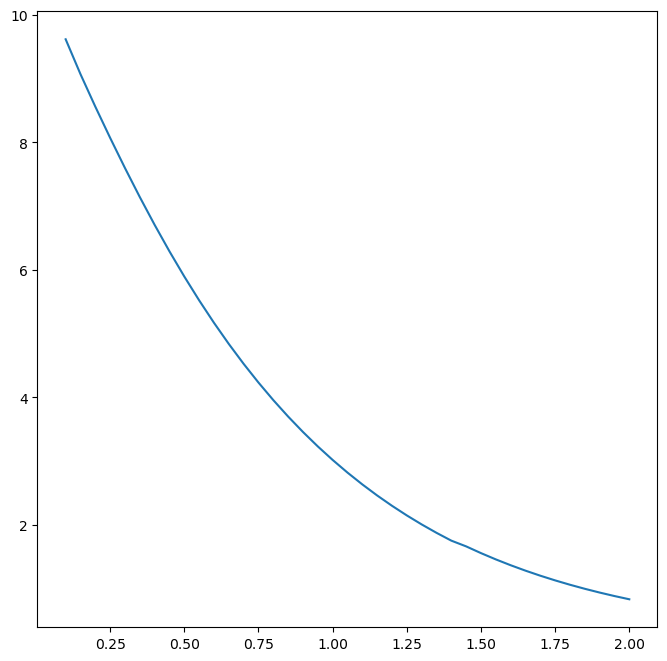

In [14]:
f,ax = plt.subplots(figsize=(8,8))
ax.plot(srange, splittings)

In [30]:
print(((nitrogen.casci_eigvals[10])-(nitrogen.casci_eigvals[9]))*219474.6)
print(((nitrogen.dsrg_mrpt2_relax_eigvals[10])-(nitrogen.dsrg_mrpt2_relax_eigvals[9]))*219474.6)

11.085414400770553
5.893524599680941


In [30]:
mol_o = pyscf.gto.M(
    verbose = 2,
    atom = '''
O 0 0 0
''',
    basis = 'uc-cc-pvtz.gbs', spin=2, charge=0, symmetry=False, nucmod='G'
)
casscf_coeffs = cq_to_pyscf(mol_o, 'O2--cc-pvtz-uc.bin')
oxygen = RelForte(mol_o, verbose=False, density_fitting=False, decontract=True)
oxygen.run_dhf(transform=False, debug=True, frozen=(0,0), dump_mo_coeff=False, with_breit=True, fake_dhf='O2--cc-pvtz-uc.bin')
oxygen.read_in_mo(relativistic=True, mo_coeff_in=casscf_coeffs, eriread='oxygen-eri')
oxygen.run_casci(cas=(6,8), rdm_level=3, relativistic=True, semi_canonicalize=True, state_avg=list(range(9)), sa_weights=[1/9]*9)
oxygen.run_dsrg_mrpt2(s=0.35, relativistic=True, relax='iterate')

In [31]:
print(((oxygen.casci_eigvals[5])-(oxygen.casci_eigvals[4]))*219474.6)
print(((oxygen.dsrg_mrpt2_relax_eigvals[5])-(oxygen.dsrg_mrpt2_relax_eigvals[4]))*219474.6)

153.23474435852268
140.90490438543975


In [28]:
mol_f = pyscf.gto.M(
    verbose = 2,
    atom = '''
F 0 0 0
''',
    basis = 'uc-cc-pvtz.gbs', spin=1, charge=0, symmetry=False, nucmod='G'
)
casscf_coeffs = cq_to_pyscf(mol_f, 'F1--cc-pvtz-uc.bin')
fluorine = RelForte(mol_f, verbose=False, density_fitting=False, decontract=True)
fluorine.run_dhf(transform=False, debug=True, frozen=(0,0), dump_mo_coeff=False, with_breit=True, fake_dhf='F1--cc-pvtz-uc.bin')
fluorine.read_in_mo(relativistic=True, mo_coeff_in=casscf_coeffs, eriread='fluorine-eri')
fluorine.run_casci(cas=(7,8), rdm_level=3, relativistic=True, semi_canonicalize=True, state_avg=list(range(6)), sa_weights=[1/6]*6)
fluorine.run_dsrg_mrpt2(s=0.35, relativistic=True, relax='iterate')

In [29]:
print(((fluorine.casci_eigvals[4])-(fluorine.casci_eigvals[3]))*219474.6)
print(((fluorine.dsrg_mrpt2_relax_eigvals[4])-(fluorine.dsrg_mrpt2_relax_eigvals[3]))*219474.6)

382.5824024165035
379.97864327412907


In [7]:
mol = pyscf.gto.M(
    verbose = 2,
    atom = '''
Na 0 0 0
''',
    basis = 'cc-pvtz', spin=1, charge=0, symmetry=False, nucmod='G'
)
casscf_coeffs = cq_to_pyscf(mol, 'Na_atom-cc-pvtz-df.bin')
a = RelForte(mol, verbose=True, density_fitting=True, decontract=False)
a.run_dhf(transform=True, debug=True, frozen=(0,0), dump_mo_coeff=False)
a.read_in_mo(relativistic=True, mo_coeff_in=casscf_coeffs)
a.run_casci(cas=(1,8), rdm_level=3, relativistic=True, semi_canonicalize=True, state_avg=[0,1,2,3,4,5,6,7], sa_weights=[0.125]*8)
a.run_dsrg_mrpt2(s=1, relativistic=True, relax='once')

              PySCF DHF interface              
###########Enabling density fitting!###########
Relativistic DHF Energy:        -162.0757804 Eh
PySCF RHF time:                    1.5206585 s
-----------------------------------------------
Will now allocate 31.073 MB memory for the DF AO ERI tensor!
Will now allocate 342.102 MB memory for the MO ERI tensor!

Timing report
....integral retrieval:            0.4212308 s
....integral transformation:       3.7549791 s
Rebuilt DHF Energy:             -162.0757804 Eh
Error to PySCF:                    0.0000000 Eh
Total time taken:                  4.1766829 s
Will now allocate 31.073 MB memory for the DF AO ERI tensor!
Will now allocate 342.102 MB memory for the MO ERI tensor!

Timing report
....integral retrieval:            0.4215169 s
....integral transformation:       3.7279148 s

            Relativistic CASCI(1,8)            
Will now allocate 0.001 MB memory for the CASCI Hamiltonian!
Time taken for 1-RDM build:        0.0006707 s
Tim

In [10]:
(a.dsrg_mrpt2_relax_eigvals[3]-a.dsrg_mrpt2_relax_eigvals[4])*27.211386245988*1000

-1.6787505290601619

In [89]:
(0.0030777643-0.0030186026)*27.211386245988*1000

1.6098718696692589

In [84]:
mol = pyscf.gto.M(
    verbose = 2,
    atom = '''
Na 0 0 0
''',
    basis = 'cc-pvdz', spin=1, charge=0, symmetry=False
)
casscf_coeffs = cq_to_pyscf(mol, 'Na_atom-cc-pvdz.bin')
a = RelForte(mol, verbose=True, density_fitting=True, decontract=False)
a.run_dhf(transform=True, debug=True, frozen=(0,0), dump_mo_coeff=False)
a.read_in_mo(relativistic=True, mo_coeff_in=casscf_coeffs)
a.run_casci(cas=(1,8), rdm_level=3, relativistic=True, semi_canonicalize=True, state_avg=[0,1,2,3,4,5,6,7], sa_weights=[0.125]*8)
a.run_dsrg_mrpt2(s=1, relativistic=True, relax='once')

              PySCF DHF interface              
Relativistic DHF Energy:        -162.0703245 Eh
PySCF RHF time:                    1.8629971 s
-----------------------------------------------
Will now allocate 429.982 MB memory for the AO ERI tensor!

Timing report
....integral retrieval:            0.6677198 s
....integral transformation:       1.0211530 s
Rebuilt DHF Energy:             -162.0703245 Eh
Error to PySCF:                    0.0000000 Eh
Total time taken:                  1.6894734 s
Will now allocate 429.982 MB memory for the AO ERI tensor!

Timing report
....integral retrieval:            0.5577283 s
....integral transformation:       0.8007717 s

            Relativistic CASCI(1,8)            
Will now allocate 0.001 MB memory for the CASCI Hamiltonian!
Time taken for 1-RDM build:        0.0006890 s
Time taken for 1-RDM build:        0.0006623 s
Time taken for 1-RDM build:        0.0008070 s
Time taken for 1-RDM build:        0.0006745 s
Time taken for 1-RDM build:     

In [85]:
(a.dsrg_mrpt2_relax_eigvals[3]-a.dsrg_mrpt2_relax_eigvals[4])*27.211386245988*1000

-1.571627082623542

In [5]:
mol = pyscf.gto.M(
    verbose = 2,
    atom = '''
Li 0 0 0
F 0 8 0
''',
    basis = 'cc-pvdz', spin=0, charge=0, symmetry=False
)
rhf = pyscf.scf.RHF(mol)
rhf.kernel()
mp2 = pyscf.mp.MP2(rhf)
mp2.kernel()

(-0.19138168591892318,
 array([[[[-8.71663514e-08,  1.27881500e-17,  1.22866468e-17, ...,
            1.50952853e-21,  1.38526523e-20,  1.06305049e-21],
          [ 1.27881500e-17, -2.14542833e-08, -5.44410960e-20, ...,
            1.15481695e-09, -4.90329774e-21,  1.69198129e-21],
          [ 1.22866468e-17, -5.44401720e-20, -2.14542833e-08, ...,
           -1.20557069e-09, -8.61799213e-21, -3.48715143e-21],
          ...,
          [ 1.50952853e-21,  1.15481695e-09, -1.20557069e-09, ...,
           -3.04826211e-05, -4.12276023e-22,  1.27151407e-22],
          [ 1.38526538e-20, -4.90329774e-21, -8.61799213e-21, ...,
           -4.12276023e-22, -3.04829389e-05,  2.68764700e-21],
          [ 1.06304664e-21,  1.69198129e-21, -3.48715143e-21, ...,
            1.27151407e-22,  2.68764700e-21, -3.04829389e-05]],
 
         [[ 7.52510261e-11, -1.83716447e-19, -1.77546479e-19, ...,
           -8.72900072e-24,  2.45608658e-22, -1.52291626e-23],
          [ 2.44006568e-21,  3.26724126e-10, -7.0

In [8]:
orbs, ao2no = mp2.make_fno()

In [10]:
orbs

array([23, 24, 25, 26, 27])

In [239]:
mol = pyscf.gto.M(
    verbose = 2,
    atom = '''
Li 0 0 0
F 0 8 0
''',
    basis = 'cc-pvdz', spin=0, charge=0, symmetry=False
)
a = RelForte(mol, verbose=True, density_fitting=False, decontract=False)
a.run_rhf(transform=True, debug=True, frozen=(0,0), dump_mo_coeff=False)
a.run_casscf_pyscf(cas=(2,8), transform=True)
a.run_casci(cas=(2,8), do_fci=False, rdm_level=3, relativistic=False, semi_canonicalize=True)

              PySCF RHF interface              
Non-relativistic RHF Energy:    -106.6684927 Eh
PySCF RHF time:                    0.4947872 s
-----------------------------------------------
Building integrals...
Integral build time:               0.2639017 s
-----------------------------------------------
Rebuilt RHF Energy:             -106.6684927 Eh
Error to PySCF:                    0.0000000 Eh
-----------------------------------------------
RHF time:                          0.7590430 s
            PySCF CASSCF interface             
Building integrals...
Integral build time:               0.1872644 s
-----------------------------------------------
CASSCF time:                       0.8674226 s

          Non-relativistic CASCI(2,8)          
Will now allocate 0.013 MB memory for the CASCI Hamiltonian!
Time taken for 1-RDM build:        0.0074897 s
Time taken for 2-RDM build:        0.0129862 s
E_frzc:                         -107.5089507 Eh
E_cas:                            -1.

In [219]:
a.casci_eigvals

array([-1.1933448 , -1.1933448 , -1.1933448 , -1.19322353, -1.14896263,
       -1.12674299, -1.12674299, -1.12674299, -1.12674299, -1.12674299,
       -1.12674299, -1.12669074, -1.12669074, -0.30945539, -0.28802801,
       -0.28802801, -0.28802801, -0.28802801, -0.28802801, -0.28802801,
       -0.21626462, -0.21626462, -0.21626462, -0.20165247, -0.20165247,
       -0.1948333 , -0.1948333 , -0.14598366])

In [220]:
mf = pyscf.scf.RHF(mol)
mf.kernel()
cas = pyscf.mcscf.CASSCF(mf, 4, 2)
res = cas.kernel()

In [229]:
res[0]

-106.80428426140361

In [244]:
mol = pyscf.gto.M(
    verbose = 2,
    atom = '''
H 0 0 0
F 0 1.5 0
''',
    basis = 'cc-pvdz', spin=0, charge=0, symmetry=False
)
rel = RelForte(mol, verbose=True, density_fitting=False, decontract=False)

rel.run_dhf(transform=True, debug=True, frozen=(0,0), dump_mo_coeff=False)
rel.run_casci(cas=(6,8), do_fci=False, rdm_level=3, relativistic=True, semi_canonicalize=True)
rel.run_dsrg_mrpt2(s=2.0, relativistic=True, relax=4)


              PySCF DHF interface              
Relativistic DHF Energy:         -99.9638776 Eh
PySCF RHF time:                    0.7922525 s
-----------------------------------------------
Will now allocate 533.795 MB memory for the AO ERI tensor!

Timing report
....integral retrieval:            0.6044996 s
....integral transformation:       1.9185348 s
Rebuilt DHF Energy:              -99.9638776 Eh
Error to PySCF:                    0.0000000 Eh
Total time taken:                  2.5234227 s

            Relativistic CASCI(6,8)            
Will now allocate 0.013 MB memory for the CASCI Hamiltonian!
Time taken for 1-RDM build:        0.0041521 s
Time taken for 2-RDM build:        0.0159478 s
Time taken for 3-RDM build:        0.1112714 s
E_frzc:                          -88.8825775 Eh
E_cas:                           -14.2940434 Eh
E_nuc:                             3.1750633 Eh
E_casci:                        -100.0015576 Eh
E0 (from RDM):                  -100.0015576 Eh
Ecorr: 

In [207]:
rel.casci_eigvals

array([-14.2940434 , -14.16175561, -14.16175561, -14.16115123,
       -14.16115123, -14.16047899, -14.16035742, -14.15129355,
       -14.15129355, -14.15069905, -14.14956177, -14.14956177,
       -13.93032912, -13.56230981, -13.56230981, -13.56145563,
       -13.56145563, -13.56064961, -13.56051309, -13.53400413,
       -13.53400413, -13.53396149, -13.4865709 , -13.4778795 ,
       -13.4778795 , -13.44471897, -13.44471897, -13.32858693])

In [138]:
mol = pyscf.gto.M(
    verbose = 2,
    atom = '''
H 0 0 0
F 0 0 1.5
''',
    basis = 'cc-pvdz', spin=0, charge=0, symmetry=False
)
rel = RelForte(mol, verbose=True, density_fitting=False, decontract=False)

rel.run_dhf(transform=True, debug=True, frozen=(0,0), dump_mo_coeff=False)
rel.run_mp2(relativistic=True)
rel.run_casci(cas=(6,8), do_fci=False, rdm_level=3, relativistic=True, semi_canonicalize=True)
rel.run_dsrg_mrpt2(s=2.0, relativistic=True, relax='once')
print(rel.dsrg_mrpt2_relax_eigvals)

              PySCF DHF interface              
Relativistic DHF Energy:         -99.9638776 Eh
PySCF RHF time:                    0.6721709 s
-----------------------------------------------
Will now allocate 533.795 MB memory for the AO ERI tensor!

Timing report
....integral retrieval:            0.3097343 s
....integral transformation:       1.0989349 s
Rebuilt DHF Energy:              -99.9638776 Eh
Error to PySCF:                    0.0000000 Eh
Total time taken:                  1.4092844 s

               Relativistic MP2                
MP2 Ecorr:                        -0.2282453 Eh
MP2 Energy:                     -100.1921229 Eh
Time taken:                        0.0588062 s

            Relativistic CASCI(6,8)            
Will now allocate 0.013 MB memory for the CASCI Hamiltonian!
Time taken for 1-RDM build:        0.0043194 s
Time taken for 2-RDM build:        0.0162132 s
Time taken for 3-RDM build:        0.1029677 s
E_frzc:                          -88.8825775 Eh
E_cas: 

In [74]:
mol = pyscf.gto.M(
    verbose = 2,
    atom = '''
H 0 0 0
F 0 1.5 0
''',
    basis = 'sto-3g', spin=0, charge=0, symmetry=False
)
a = RelForte(mol, verbose=True, density_fitting=True, decontract=False)
a.run_dhf(transform=True, debug=True, frozen=(0,0), dump_mo_coeff=False)
#a.run_casci(do_fci=True, relativistic=True)
aci = ACISolver(a, pspace0=[1023], verbose=True, cas=(10,12), sigma=1e-3, gamma=1e-3, relativistic=True, maxiter=5)
aci.run_aci()

              PySCF DHF interface              
###########Enabling density fitting!###########
Relativistic DHF Energy:         -98.4848604 Eh
PySCF RHF time:                    0.5293863 s
-----------------------------------------------
Will now allocate 0.438 MB memory for the DF AO ERI tensor!
Will now allocate 0.332 MB memory for the MO ERI tensor!

Timing report
....integral retrieval:            0.0066619 s
....integral transformation:       0.0022418 s
Rebuilt DHF Energy:              -98.4848604 Eh
Error to PySCF:                    0.0000000 Eh
Total time taken:                  0.0093405 s
Iteration 1
number of p space determinants: 1
Will now allocate 0.000 MB memory for the CASCI Hamiltonian!
Time taken for 1-RDM build:        0.0000365 s
p space energy: -98.4848603683191
number of fois determinants: 65
number of model space determinants: 5
pt2 energy: -0.0008513880793405149
Will now allocate 0.000 MB memory for the CASCI Hamiltonian!
model space energy: -98.58631985330098

In [75]:
aci.run_tdaci(0.05, 10000, 2, 'rk4')

Will now allocate 0.154 MB memory for the CASCI Hamiltonian!


In [90]:
mol = pyscf.gto.M(
    verbose = 2,
    atom = '''
H 0 0 0
F 0 1.5 0
''',
    basis = 'cc-pvdz', spin=0, charge=0, symmetry=False
)
rel = RelForte(mol, verbose=True, density_fitting=False, decontract=False)

rel.run_dhf(transform=True, debug=True, frozen=(0,0), dump_mo_coeff=False)
rel.run_casci(cas=(6,8), do_fci=False, rdm_level=1, relativistic=True, semi_canonicalize=False)

rel_semi = RelForte(mol, verbose=True, density_fitting=False, decontract=False)

rel_semi.run_dhf(transform=True, debug=True, frozen=(0,0), dump_mo_coeff=False)
rel_semi.run_casci(cas=(6,8), do_fci=False, rdm_level=1, relativistic=True, semi_canonicalize=True)

              PySCF DHF interface              
Relativistic DHF Energy:         -99.9638776 Eh
PySCF RHF time:                    0.7548428 s
-----------------------------------------------
Will now allocate 533.795 MB memory for the AO ERI tensor!

Timing report
....integral retrieval:            0.3727932 s
....integral transformation:       1.1494393 s
Rebuilt DHF Energy:              -99.9638776 Eh
Error to PySCF:                    0.0000000 Eh
Total time taken:                  1.5229433 s

            Relativistic CASCI(6,8)            
Will now allocate 0.013 MB memory for the CASCI Hamiltonian!
Time taken for 1-RDM build:        0.0045273 s
E_frzc:                          -88.8825775 Eh
E_cas:                           -14.2940434 Eh
E_nuc:                             3.1750633 Eh
E_casci:                        -100.0015576 Eh
Ecorr:                            -0.0376800 Eh

Timing summary
... Hamil build:                    0.0130484 s
... Hamil diag:                     0

In [91]:
hcore_semi = np.einsum('ip,ij,jq->pq',np.conj(rel_semi.semicanonicalizer),rel.dhf_hcore_mo,(rel_semi.semicanonicalizer))

In [93]:
np.allclose(rel.dhf_hcore_mo,np.einsum('ip,pq,jq->ij',(rel_semi.semicanonicalizer),hcore_semi,np.conj(rel_semi.semicanonicalizer),optimize='optimal'))

False

In [349]:
mol = pyscf.gto.M(
    verbose = 2,
    atom = '''
H 0 0 0
F 0 1.5 0
''',
    basis = 'cc-pvdz', spin=0, charge=0, symmetry=False
)
a = RelForte(mol, verbose=True, density_fitting=False, decontract=False)

a.run_rhf(transform=True, debug=False, frozen=(0,0), dump_mo_coeff=False)
#a.run_dhf(transform=False, debug=True, frozen=(0,0), dump_mo_coeff=True)
#a.read_in_mo(relativistic=False, mo_coeff_in='mo_coeff.npy')
a.run_mp2(relativistic=False)
a.run_casci(cas=(6,8), do_fci=False, rdm_level=3, relativistic=False, semi_canonicalize=True)
a.run_dsrg_mrpt2(s=2.0, relativistic=False, relax=None)

              PySCF RHF interface              
Non-relativistic RHF Energy:     -99.8728525 Eh
PySCF RHF time:                    0.3237703 s
-----------------------------------------------
Building integrals...
Integral build time:               0.0235095 s
-----------------------------------------------
RHF time:                          0.3473506 s

             Non-relativistic MP2              
MP2 Ecorr:                        -0.2281882 Eh
MP2 Energy:                     -100.1010407 Eh
Error to PySCF:                   -0.0000001 Eh
Time taken:                        0.0833399 s

          Non-relativistic CASCI(6,8)          
Will now allocate 0.013 MB memory for the CASCI Hamiltonian!
Time taken for 1-RDM build:        0.0067089 s
Time taken for 2-RDM build:        0.0265238 s
Time taken for 3-RDM build:        0.1535099 s
E_frzc:                          -88.7919901 Eh
E_cas:                           -14.2934660 Eh
E_nuc:                             3.1750633 Eh
E_casci:  

In [74]:
mol = pyscf.gto.M(
    verbose = 2,
    atom = '''
H 0 0 0
F 0 1.5 0
''',
    basis = 'cc-pvdz', spin=0, charge=0, symmetry=False
)
a = RelForte(mol, verbose=True, density_fitting=False, decontract=False)

a.run_rhf(transform=True, debug=True, frozen=(0,0), dump_mo_coeff=False)
#a.run_dhf(transform=False, debug=True, frozen=(0,0), dump_mo_coeff=True)
#a.read_in_mo(relativistic=False, mo_coeff_in='mo_coeff.npy')
a.run_mp2(relativistic=False)
a.run_casci(cas=(6,8), do_fci=False, rdm_level=3, relativistic=False, semi_canonicalize=True)
a.run_dsrg_mrpt2(s=2.0, relativistic=False, relax='iterate')
assert (np.isclose(a.e_dsrg_mrpt2, -100.1095772076021, atol=1e-8, rtol=1e-8))

              PySCF RHF interface              
Non-relativistic RHF Energy:     -99.8728525 Eh
PySCF RHF time:                    0.3867183 s
-----------------------------------------------
Building integrals...
Integral build time:               0.1160352 s
-----------------------------------------------
Rebuilt RHF Energy:              -99.8728525 Eh
Error to PySCF:                    0.0000000 Eh
-----------------------------------------------
RHF time:                          0.5030639 s

             Non-relativistic MP2              
MP2 Ecorr:                        -0.2281882 Eh
MP2 Energy:                     -100.1010407 Eh
Error to PySCF:                   -0.0000001 Eh
Time taken:                        0.0948341 s

          Non-relativistic CASCI(6,8)          
Will now allocate 0.013 MB memory for the CASCI Hamiltonian!
Time taken for 1-RDM build:        0.0070257 s
Time taken for 2-RDM build:        0.0265973 s
Time taken for 3-RDM build:        0.1728690 s
E_frzc:   

In [45]:
a.e_casci_save

-99.91039280165454

In [228]:
mol = pyscf.gto.M(
    verbose = 2,
    atom = '''
H 0 0 0
F 0 1.5 0
''',
    basis = 'cc-pvdz', spin=0, charge=0, symmetry=False
)
ref = RelForte(mol, verbose=True, density_fitting=False, decontract=False)

ref.run_rhf(transform=True, debug=False, frozen=(0,0), dump_mo_coeff=False)
#a.run_dhf(transform=False, debug=True, frozen=(0,0), dump_mo_coeff=True)
#a.read_in_mo(relativistic=False, mo_coeff_in='mo_coeff.npy')
ref.run_mp2(relativistic=False)
ref.run_casci(cas=(6,8), do_fci=False, rdm_level=3, relativistic=False, semi_canonicalize=True)
ref.do_dsrg_mrpt2(s=2.0, relativistic=False, relax='once')
assert (np.isclose(ref.e_dsrg_mrpt2_relaxed, -100.1095390, atol=1e-8, rtol=1e-8))

              PySCF RHF interface              
Non-relativistic RHF Energy:     -99.8728525 Eh
PySCF RHF time:                    0.3643064 s
-----------------------------------------------
Building integrals...
Integral build time:               0.0245945 s
-----------------------------------------------
RHF time:                          0.3889697 s

             Non-relativistic MP2              
MP2 Ecorr:                        -0.2281882 Eh
MP2 Energy:                     -100.1010407 Eh
Error to PySCF:                   -0.0000001 Eh
Time taken:                        0.0866919 s

          Non-relativistic CASCI(6,8)          
Will now allocate 0.013 MB memory for the CASCI Hamiltonian!
Time taken for 1-RDM build:        0.0074434 s
Time taken for 2-RDM build:        0.0291743 s
Time taken for 3-RDM build:        0.1467495 s
E_frzc:                          -88.7919901 Eh
E_cas:                           -14.2934660 Eh
E_nuc:                             3.1750633 Eh
E_casci:  

### Test cases, do NOT DELETE!
```
mol = pyscf.gto.M(
    verbose = 2,
    atom = '''
H 0 0 0
Li 0 1.5 0
''',
    basis = 'sto-3g', spin=0, charge=0, symmetry=False
)
a = mySCF(mol, verbose=True, density_fitting=False, decontract=False)

a.run_rhf(build_spinorb_ints=True)
a.run_casci(cas=(2,4), do_fci=False, rdm_level=3, relativistic=False, semi_canonicalize=True)
a.do_dsrg_mrpt2(s=2.0, relativistic=False)

assert (np.isclose(a.e_dsrg_mrpt2,-0.0121191)) # This is from the Wick&d notebook, Forte gives something slightly different
```
Output:
```
Non-relativistic RHF Energy:      -7.8633576 Eh
Will now allocate 0.001 MB memory for the CASCI Hamiltonian!
Time taken for 1-RDM build:        0.0016577 s

Time taken for 2-RDM build:        0.0009291 s

Non-relativistic CASCI(2,4)
E_frzc:                            -7.8403060 Eh
E_cas:                             -1.0816282 Eh
E_nuc:                              1.0583544 Eh
E_casci:                           -7.8635798 Eh
E0 (from RDM):                -7.8635798+0.0000000j Eh
Ecorr:                             -0.0002222 Eh
Error to PySCF:        -0.0000000 Eh

Time taken:                         0.7129242 s
... Hamil build:                    0.0007181 s
... Hamil diag:                     0.0000954 s
... RDM build:                      0.7115510 s
DSRG-MRPT2 energy:            -0.0121191 Eh
Time taken:              0.0298 s
```
```
mol = pyscf.gto.M(
    verbose = 2,
    atom = '''
H 0 0 0
F 0 1.5 0
''',
    basis = 'cc-pvdz', spin=0, charge=0, symmetry=False
)
a = mySCF(mol, verbose=True, density_fitting=False, decontract=False)

a.run_rhf(build_spinorb_ints=True, debug=True, frozen=(0,0))
a.run_mp2(relativistic=False)
a.run_casci(cas=(6,8), do_fci=False, rdm_level=3, relativistic=False, semi_canonicalize=False)
a.do_dsrg_mrpt2(s=2.0, relativistic=False, relax='once')
assert (np.isclose(a.e_dsrg_mrpt2_relaxed, -100.1078658))
```
Output:
```
Non-relativistic RHF Energy:     -99.8728525 Eh
Rebuilt RHF Energy:              -99.8728525 Eh
Diff:           1.136868e-13
Diff 1e:        1.136868e-13
Diff 2e:        7.105427e-15
Non-relativistic MP2 Ecorr:           -0.2281882 Eh
Non-relativistic MP2 Energy:        -100.1010407 Eh
Time taken:                        0.0771186 s

Error to PySCF:        -0.0000001 Eh
Will now allocate 0.013 MB memory for the CASCI Hamiltonian!
Time taken for 1-RDM build:        0.0066328 s

Time taken for 2-RDM build:        0.0250289 s

Time taken for 3-RDM build:        0.1648664 s

Non-relativistic CASCI(6,8)
E_frzc:                           -88.7919901 Eh
E_cas:                            -14.2934660 Eh
E_nuc:                              3.1750633 Eh
E_casci:                          -99.9103928 Eh
E0 (from RDM):                -99.9103928+0.0000000j Eh
Ecorr:                             -0.0375403 Eh
Error to PySCF:         0.0000000 Eh

Time taken:                         0.2182207 s
... Hamil build:                    0.0196035 s
... Hamil diag:                     0.0002217 s
... RDM build:                      0.1982520 s
DSRG-MRPT2 energy:            -0.1972827 Eh
Time taken:              0.7197 s
Will now allocate 0.013 MB memory for the CASCI Hamiltonian!
Relaxation energy:              -0.0001903 Eh
DSRG-MRPT2 relaxed energy:    -100.1078658 Eh
Time taken:                0.0234 s
```

In [203]:
mol = pyscf.gto.M(
    verbose = 2,
    atom = '''
H 0 0 0
F 0 1.5 0
''',
    basis = 'cc-pvdz', spin=0, charge=0, symmetry=False
)
a = RelForte(mol, verbose=True, density_fitting=False, decontract=False)

a.run_rhf(transform=True, debug=False, frozen=(0,0), dump_mo_coeff=False)
a.run_casci(cas=(6,8), do_fci=False, rdm_level=3, relativistic=False, semi_canonicalize=True)

              PySCF RHF interface              
Non-relativistic RHF Energy:     -99.8728525 Eh
PySCF RHF time:                    0.5197847 s
-----------------------------------------------
Building integrals...
Integral build time:               0.0327785 s
-----------------------------------------------
RHF time:                          0.5526748 s

          Non-relativistic CASCI(6,8)          
Will now allocate 0.013 MB memory for the CASCI Hamiltonian!
Time taken for 1-RDM build:        0.0074279 s
Time taken for 2-RDM build:        0.0284319 s
Time taken for 3-RDM build:        0.1481564 s
E_frzc:                          -88.7919901 Eh
E_cas:                           -14.2934660 Eh
E_nuc:                             3.1750633 Eh
E_casci:                         -99.9103928 Eh
E0 (from RDM):                   -99.9103928 Eh
Ecorr:                            -0.0375403 Eh
Error to PySCF:                    0.0000000 Eh

Timing summary
... Hamil build:                    0.0234

In [95]:
mol = pyscf.gto.M(
    verbose = 2,
    atom = '''
H 0 0 0
F 0 1.5 0
''',
    basis = 'cc-pvdz', spin=0, charge=0, symmetry=False
)
a = RelForte(mol, verbose=True, density_fitting=False, decontract=False)

#a.run_rhf(transform=True, debug=False, frozen=(0,0), dump_mo_coeff=False)
a.run_dhf(transform=True, debug=True, frozen=(0,0), dump_mo_coeff=True)
#a.read_in_mo(relativistic=False, mo_coeff_in='mo_coeff.npy')
a.run_mp2(relativistic=True)
a.run_casci(cas=(6,8), do_fci=False, rdm_level=3, relativistic=True, semi_canonicalize=True)
a.do_dsrg_mrpt2(s=2.0, relativistic=True, relax='once')

              PySCF DHF interface              
Relativistic DHF Energy:         -99.9638776 Eh
PySCF RHF time:                    0.7056489 s
-----------------------------------------------
Dumping MO coefficients to mo_coeff
Will now allocate 533.795 MB memory for the AO ERI tensor!

Timing report
....integral retrieval:            0.4483254 s
....integral transformation:       1.4116316 s
Rebuilt DHF Energy:              -99.9638776 Eh
Error to PySCF:                    0.0000000 Eh
Total time taken:                  1.8643978 s

               Relativistic MP2                
MP2 Ecorr:                        -0.2282453 Eh
MP2 Energy:                     -100.1921229 Eh
Time taken:                        0.0543275 s

            Relativistic CASCI(6,8)            
Will now allocate 0.013 MB memory for the CASCI Hamiltonian!
Time taken for 1-RDM build:        0.0050619 s
Time taken for 2-RDM build:        0.0161626 s
Time taken for 3-RDM build:        0.1013861 s
E_frzc:            

### Test cases, do NOT DELETE!
```
mol = pyscf.gto.M(
    verbose = 2,
    atom = '''
H 0 0 0
Li 0 1.5 0
''',
    basis = 'sto-3g', spin=0, charge=0, symmetry=False
)
a = mySCF(mol, verbose=True, density_fitting=False, decontract=False)

a.run_rhf(build_spinorb_ints=True)
a.run_casci(cas=(2,4), do_fci=False, rdm_level=3, relativistic=False, semi_canonicalize=True)
a.do_dsrg_mrpt2(s=2.0, relativistic=False)

assert (np.isclose(a.e_dsrg_mrpt2,-0.0121191)) # This is from the Wick&d notebook, Forte gives something slightly different
```
Output:
```
Non-relativistic RHF Energy:      -7.8633576 Eh
Will now allocate 0.001 MB memory for the CASCI Hamiltonian!
Time taken for 1-RDM build:        0.0016577 s

Time taken for 2-RDM build:        0.0009291 s

Non-relativistic CASCI(2,4)
E_frzc:                            -7.8403060 Eh
E_cas:                             -1.0816282 Eh
E_nuc:                              1.0583544 Eh
E_casci:                           -7.8635798 Eh
E0 (from RDM):                -7.8635798+0.0000000j Eh
Ecorr:                             -0.0002222 Eh
Error to PySCF:        -0.0000000 Eh

Time taken:                         0.7129242 s
... Hamil build:                    0.0007181 s
... Hamil diag:                     0.0000954 s
... RDM build:                      0.7115510 s
DSRG-MRPT2 energy:            -0.0121191 Eh
Time taken:              0.0298 s
```
```
mol = pyscf.gto.M(
    verbose = 2,
    atom = '''
H 0 0 0
F 0 1.5 0
''',
    basis = 'cc-pvdz', spin=0, charge=0, symmetry=False
)
a = mySCF(mol, verbose=True, density_fitting=False, decontract=False)

a.run_rhf(build_spinorb_ints=True, debug=True, frozen=(0,0))
a.run_mp2(relativistic=False)
a.run_casci(cas=(6,8), do_fci=False, rdm_level=3, relativistic=False, semi_canonicalize=False)
a.do_dsrg_mrpt2(s=2.0, relativistic=False, relax='once')
assert (np.isclose(a.e_dsrg_mrpt2_relaxed, -100.1078658))
```
Output:
```
Non-relativistic RHF Energy:     -99.8728525 Eh
Rebuilt RHF Energy:              -99.8728525 Eh
Diff:           1.136868e-13
Diff 1e:        1.136868e-13
Diff 2e:        7.105427e-15
Non-relativistic MP2 Ecorr:           -0.2281882 Eh
Non-relativistic MP2 Energy:        -100.1010407 Eh
Time taken:                        0.0771186 s

Error to PySCF:        -0.0000001 Eh
Will now allocate 0.013 MB memory for the CASCI Hamiltonian!
Time taken for 1-RDM build:        0.0066328 s

Time taken for 2-RDM build:        0.0250289 s

Time taken for 3-RDM build:        0.1648664 s

Non-relativistic CASCI(6,8)
E_frzc:                           -88.7919901 Eh
E_cas:                            -14.2934660 Eh
E_nuc:                              3.1750633 Eh
E_casci:                          -99.9103928 Eh
E0 (from RDM):                -99.9103928+0.0000000j Eh
Ecorr:                             -0.0375403 Eh
Error to PySCF:         0.0000000 Eh

Time taken:                         0.2182207 s
... Hamil build:                    0.0196035 s
... Hamil diag:                     0.0002217 s
... RDM build:                      0.1982520 s
DSRG-MRPT2 energy:            -0.1972827 Eh
Time taken:              0.7197 s
Will now allocate 0.013 MB memory for the CASCI Hamiltonian!
Relaxation energy:              -0.0001903 Eh
DSRG-MRPT2 relaxed energy:    -100.1078658 Eh
Time taken:                0.0234 s
```

In [96]:
mol = pyscf.gto.M(
    verbose = 2,
    atom = '''
H 0 0 0
F 0 1.5 0
''',
    basis = 'sto-3g', spin=0, charge=0, symmetry=False
)
a = RelForte(mol, verbose=True, density_fitting=False, decontract=False)
a.run_dhf(transform=False, debug=True, frozen=(0,0), dump_mo_coeff=False)
cq_dhf_coeffs = cq_to_pyscf(mol, 'HF-dhf-sto3g.bin')
a.read_in_mo(relativistic=True, mo_coeff_in=cq_dhf_coeffs, debug=True)

Exception ignored in: <function _TemporaryFileCloser.__del__ at 0x7f661fd0e5e0>
Traceback (most recent call last):
  File "/home/brianz98/anaconda3/lib/python3.8/tempfile.py", line 440, in __del__
    self.close()
  File "/home/brianz98/anaconda3/lib/python3.8/tempfile.py", line 436, in close
    unlink(self.name)
FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/zdj51/Documents/code/phd/4c-DSRG-MRPT2/tmpi1ao1izg'


              PySCF DHF interface              
Relativistic DHF Energy:         -98.4847545 Eh
PySCF RHF time:                    0.4334400 s
-----------------------------------------------
Will now allocate 5.308 MB memory for the AO ERI tensor!

Timing report
....integral retrieval:            0.0219235 s
....integral transformation:       0.0045705 s
Rebuilt DHF Energy:              -98.4847545 Eh
Error to PySCF:                   -0.0000000 Eh
Diff 1e:                          -0.0000000 Eh
Diff 2e:                           0.0000000 Eh


In [10]:
mol = pyscf.gto.M(
    verbose = 2,
    atom = '''
H 0 0 0
F 0 1.5 0
''',
    basis = 'cc-pvtz', spin=0, charge=0, symmetry=False
)
a = RelForte(mol, verbose=True, density_fitting=True, decontract=False)
a.run_dhf(transform=False, debug=True, frozen=(0,0), dump_mo_coeff=False)
cq_dhf_coeffs = cq_to_pyscf(mol, 'HF-dhf-ccpvtz-df.bin')
a.read_in_mo(relativistic=True, mo_coeff_in=cq_dhf_coeffs, debug=True)

              PySCF DHF interface              
###########Enabling density fitting!###########
Relativistic DHF Energy:         -99.9992011 Eh
PySCF RHF time:                    2.1728055 s
-----------------------------------------------
Will now allocate 27.011 MB memory for the DF AO ERI tensor!
Will now allocate 959.513 MB memory for the MO ERI tensor!

Timing report
....integral retrieval:            0.9651639 s
....integral transformation:       6.8947234 s
Rebuilt DHF Energy:              -99.9992011 Eh
Error to PySCF:                    0.0000000 Eh
Diff 1e:                          -0.0000259 Eh
Diff 2e:                           0.0000259 Eh


In [94]:
mol = pyscf.gto.M(
    verbose = 2,
    atom = '''
H 0 0 0
F 0 1.5 0
''',
    basis = 'cc-pvdz', spin=0, charge=0, symmetry=False
)
a = RelForte(mol, verbose=True, density_fitting=False, decontract=False)
a.run_dhf(transform=False, debug=True, frozen=(0,0), dump_mo_coeff=False)
cq_dhf_coeffs = cq_to_pyscf(mol, 'HF-casscf.bin')
a.read_in_mo(relativistic=True, mo_coeff_in=cq_dhf_coeffs)
a.run_casci(cas=(6,8), do_fci=False, rdm_level=3, relativistic=True, semi_canonicalize=True)
assert (np.isclose(a.e_casci, -100.0313089998, atol=1e-8, rtol=1e-8)) # This value is directly from ChronusQ
a.do_dsrg_mrpt2(s=2.0, relativistic=True, relax='once')

              PySCF DHF interface              
Relativistic DHF Energy:         -99.9638776 Eh
PySCF RHF time:                    0.6633656 s
-----------------------------------------------
Will now allocate 533.795 MB memory for the AO ERI tensor!

Timing report
....integral retrieval:            0.3190272 s
....integral transformation:       1.3303208 s

            Relativistic CASCI(6,8)            
Will now allocate 0.013 MB memory for the CASCI Hamiltonian!
Time taken for 1-RDM build:        0.0043604 s
Time taken for 2-RDM build:        0.0163100 s
Time taken for 3-RDM build:        0.1043813 s
E_frzc:                          -87.2178335 Eh
E_cas:                           -15.9885388 Eh
E_nuc:                             3.1750633 Eh
E_casci:                        -100.0313090 Eh
E0 (from RDM):                   -97.8833395 Eh
Ecorr:                            -0.0674314 Eh

Timing summary
... Hamil build:                    0.0124662 s
... Hamil diag:                     0.

In [1431]:
# https://en.wikipedia.org/wiki/Table_of_spherical_harmonics#Real_spherical_harmonics
# https://pyscf.org/user/gto.html#basis-set
# Psi4 orders 0,+1,-1,...,+l,-l always
psi4_coeff = np.load('psi4_casscf.npy')
psi4_reorder = psi4_coeff[[0,1,3,4,2,5,6,7,9,10,8,12,13,11,18,16,14,15,17],:]

In [1434]:
mol = pyscf.gto.M(
    verbose = 2,
    atom = '''
H 0 0 0
F 0 0 1.5
''',
    basis = 'cc-pvdz', spin=0, charge=0, symmetry=False
)

a = RelForte(mol, verbose=True, density_fitting=False, decontract=False)
a.run_rhf(transform=False, debug=False, frozen=(0,0), dump_mo_coeff=False)
a.read_in_mo(relativistic=False, mo_coeff_in=psi4_reorder)
#a.run_dhf(transform=False, debug=True, frozen=(0,0), dump_mo_coeff=True)
a.run_casci(cas=(6,8), do_fci=False, rdm_level=3, relativistic=False, semi_canonicalize=True)
a.do_dsrg_mrpt2(s=2.0, relativistic=False, relax='once')
assert(np.isclose(a.e_dsrg_mrpt2_relaxed, -100.10611631764026))

              PySCF RHF interface              
Non-relativistic RHF Energy:     -99.8728525 Eh
PySCF RHF time:                    0.3246958 s
-----------------------------------------------
Building integrals...
Integral build time:               0.0268114 s
-----------------------------------------------

          Non-relativistic CASCI(6,8)          
Will now allocate 0.013 MB memory for the CASCI Hamiltonian!
Time taken for 1-RDM build:        0.0067270 s
Time taken for 2-RDM build:        0.0265081 s
Time taken for 3-RDM build:        0.1264923 s
E_frzc:                          -88.8375966 Eh
E_cas:                           -14.2771745 Eh
E_nuc:                             3.1750633 Eh
E_casci:                         -99.9397078 Eh
E0 (from RDM):                   -99.9397078 Eh
Ecorr:                            -0.0668553 Eh
Error to PySCF:                   -0.0293150 Eh

Timing summary
... Hamil build:                    0.0224583 s
... Hamil diag:                     0.000